<a href="https://colab.research.google.com/github/mansikataria/FacialExpressionRecognition/blob/main/FERResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import pandas as pd
import os
import torchvision.transforms as transforms

In [2]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 200
batch_size = 32
start_epoch = 0  # start from epoch 0 
learning_rate_decay_start = 30  # 50
learning_rate_decay_every = 5 # 5
learning_rate_decay_rate = 0.9 # 0.9
lr = 0.01
use_cuda = True

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

BASE_PATH = '/content/drive/MyDrive/Colab Notebooks'
sys.path.insert(0,BASE_PATH)

Mounted at /content/drive


Reading the FER2013 dataset from the CSV

In [4]:
FER2013_PATH_FILE_NAME = 'fer2013.csv'
# data = pd.read_csv(BASE_PATH + '/' + FER2013_PATH_FILE_NAME)
# data.head(5)

In [5]:
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

Import ResNet18 model from file

In [6]:
# upload external file before import
from google.colab import files
files.upload()
import resnet


Saving resnet.py to resnet.py


In [7]:
files.upload()
import utils

Saving utils.py to utils.py


In [8]:
model = resnet.ResNet18()

In [ ]:
if use_cuda:
    model.cuda()

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import torchvision

from torch.autograd import Variable

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

In [ ]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    global Train_acc
    model.train()
    train_loss = 0
    epoch_loss = 0
    correct = 0
    total = 0

    if epoch > learning_rate_decay_start and learning_rate_decay_start >= 0:
        frac = (epoch - learning_rate_decay_start) // learning_rate_decay_every
        decay_factor = learning_rate_decay_rate ** frac
        current_lr = lr * decay_factor
        utils.set_lr(optimizer, current_lr)  # set the decayed rate
    else:
        current_lr = lr
    print('learning_rate: %s' % str(current_lr))

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = model(inputs)
        # print('targets: ', targets)
        # print('outputs: ', outputs)
        loss = criterion(outputs, targets)
        # print(loss)
        loss.backward()
        # print(loss.data)
        utils.clip_gradient(optimizer, 0.1)
        optimizer.step()
        # print(loss.data.shape)
        train_loss += loss.data
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        epoch_loss = train_loss/(batch_idx+1)
        utils.progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    train_losses.append(epoch_loss)
    # print('loss: ', train_loss)
    Train_acc = 100.*correct/total
    train_acc.append(Train_acc)
    # print('train_acc: ', train_loss)

def PublicTest(epoch):
    global PublicTest_acc
    global best_PublicTest_acc
    global best_PublicTest_acc_epoch
    best_PublicTest_acc = 0
    best_PublicTest_acc_epoch = 0
    model.eval()
    PublicTest_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(PublicTestloader):
        # print(batch_idx)
        bs, ncrops, c, h, w = np.shape(inputs)
        # bs, c, h, w = np.shape(inputs)
        inputs = inputs.view(-1, c, h, w)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = model(inputs)
        outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops
        loss = criterion(outputs_avg, targets)
        PublicTest_loss += loss.data
        _, predicted = torch.max(outputs_avg.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        utils.progress_bar(batch_idx, len(PublicTestloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                           % (PublicTest_loss / (batch_idx + 1), 100. * correct / total, correct, total))

    # Save checkpoint.
    PublicTest_acc = 100.*correct/total
    if PublicTest_acc > best_PublicTest_acc:
        print('Saving..')
        print("best_PublicTest_acc: %0.3f" % PublicTest_acc)
        state = {
            'net': model.state_dict() if use_cuda else model,
            'acc': PublicTest_acc,
            'epoch': epoch,
        }
        # if not os.path.isdir(path):
        #     os.mkdir(path)
        # torch.save(state, os.path.join(path,'PublicTest_model.t7'))
        best_PublicTest_acc = PublicTest_acc
        best_PublicTest_acc_epoch = epoch

def PrivateTest(epoch):
    global PrivateTest_acc
    best_PrivateTest_acc = 0
    best_PrivateTest_acc_epoch = 0
    model.eval()
    PrivateTest_loss = 0
    epoch_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(PrivateTestloader):
        bs, ncrops, c, h, w = np.shape(inputs)
        # bs, c, h, w = np.shape(inputs)
        inputs = inputs.view(-1, c, h, w)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = model(inputs)
        outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops
        loss = criterion(outputs_avg, targets)
        PrivateTest_loss += loss.data
        _, predicted = torch.max(outputs_avg.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        epoch_loss = PrivateTest_loss / (batch_idx + 1)
        utils.progress_bar(batch_idx, len(PublicTestloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (epoch_loss, 100. * correct / total, correct, total))
    # Save checkpoint.
    PrivateTest_acc = 100.*correct/total
    val_losses.append(epoch_loss)
    val_acc.append(PrivateTest_acc)

    if PrivateTest_acc > best_PrivateTest_acc:
        print('Saving..')
        print("best_PrivateTest_acc: %0.3f" % PrivateTest_acc)
        state = {
            'net': model.state_dict() if use_cuda else model,
	        'best_PublicTest_acc': best_PublicTest_acc,
            'best_PrivateTest_acc': PrivateTest_acc,
    	    'best_PublicTest_acc_epoch': best_PublicTest_acc_epoch,
            'best_PrivateTest_acc_epoch': epoch,
        }
        # if not os.path.isdir(path):
        #     os.mkdir(path)
        # torch.save(state, os.path.join(path,'PrivateTest_model.t7'))
        best_PrivateTest_acc = PrivateTest_acc
        best_PrivateTest_acc_epoch = epoch


Define transformations

In [ ]:


transformations = transforms.Compose([
    transforms.RandomCrop(44),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.ColorJitter(brightness=.3),
    transforms.ToTensor()
])

In [10]:
files.upload()
import dataset

Saving dataset.py to dataset.py


In [ ]:
trainset = dataset.FER2013(BASE_PATH + '/' + FER2013_PATH_FILE_NAME, split = 'Train', transform=transformations)
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=batch_size, num_workers=1)

In [ ]:
# dataiter = iter(trainloader)
# images, labels = dataiter.next()

In [ ]:
# from skimage.transform import resize
# from skimage import img_as_ubyte
# import torchvision.transforms as T

# # functions to show an image
# def imshow(img):
#     im = Image.fromarray((img * 255).astype(np.uint8))
#     # sharpness_adjuster = T.RandomAdjustSharpness(sharpness_factor=3)
#     # sharpened_imgs = [sharpness_adjuster(im) for _ in range(4)]
#     # jitter = T.ColorJitter(brightness=.5)
#     jittered_imgs = [sample_transformations(im) for _ in range(4)]
#     # plt.imshow(sharpened_imgs)
#     npimage1, npimage2, npimage3, npimage4 = [np.array(jittered_img) for jittered_img in jittered_imgs]
#     for sharpened in jittered_imgs:
#       plt.imshow(sharpened)
#       plt.show()
#     print('==============================')
#     npimg = img
#     # print(npimg.dtype)
#     # print(npimg.shape)
#     plt.imshow(img)
#     plt.show()


# for i in range(1):
#     # get some random training images
    
#     print(images.shape)
#     # img = torchvision.utils.make_grid(images[0])
#     img = images[0]
#     img = np.transpose(img, (1, 2, 0))
#     img = img[:, :, 0]
#     print(img.shape)
#     img2 = np.zeros((44, 44, 3))
#     img2[:,:,0] = img
#     img2[:,:,1] = img
#     img2[:,:,2] = img
#     # show images
#     imshow(img2)
#     # print labels
#     print(' '.join('%10s' % emotion_labels[labels[j]] for j in range(1)))

In [ ]:
cut_size=44
transformations = transforms.Compose([
   transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])

In [ ]:
PublicTestset = dataset.FER2013(BASE_PATH + '/' + FER2013_PATH_FILE_NAME, split = 'Public_Test', transform=transformations)
PublicTestloader = torch.utils.data.DataLoader(PublicTestset, batch_size=batch_size, shuffle=False, num_workers=1)
PrivateTestset = dataset.FER2013(BASE_PATH + '/' + FER2013_PATH_FILE_NAME, split = 'Private_Test', transform=transformations)
PrivateTestloader = torch.utils.data.DataLoader(PrivateTestset, batch_size=batch_size, shuffle=False, num_workers=1)

In [ ]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

for epoch in range(start_epoch, num_epochs):
    train(epoch)
    PublicTest(epoch)
    PrivateTest(epoch)

# New section

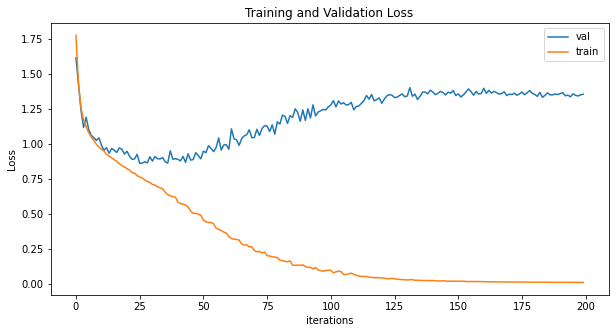

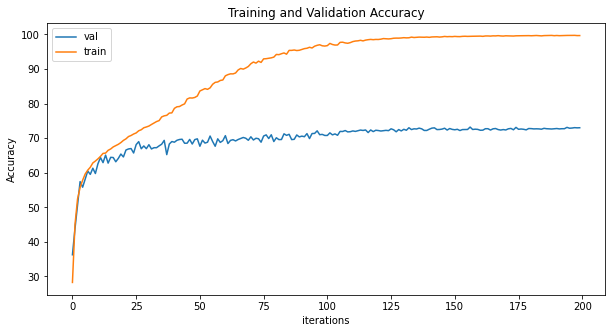

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_acc,label="val")
plt.plot(train_acc,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Save model using pickle

# Import pickle Package
import pickle

# Save the Modle to file in the current working directory
Pkl_Filename = BASE_PATH + "/fer-pytorch-resnet-pkl/Pickle_FER_Model.pkl"  
os.makedirs(os.path.dirname(Pkl_Filename), exist_ok=True)

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

In [11]:
path_model=BASE_PATH + '/fer-pytorch-resnet-12'

In [ ]:
# path_model=BASE_PATH + '/fer-pytorch-resnet-2'
# torch.save(model.state_dict(), path_model)
torch.save(model, path_model)

In [12]:
# saved_model = resnet.ResNet18()


# saved_model.load_state_dict(torch.load(path_model))
saved_model = torch.load(path_model)

if use_cuda:
    saved_model.cuda()


In [ ]:
# img_path=BASE_PATH + '/images/fer_test_2.jpg'
# classify(img_path)
# img_path=BASE_PATH + '/images/fer_test_3.jpg'
# classify(img_path)
# img_path=BASE_PATH + '/images/fer_test_4.png'
# classify(img_path)

img_path=BASE_PATH + '/images/parth-fer-1-1.jpg'
classify(img_path)
img_path=BASE_PATH + '/images/parth-fer-2-1.jpg'
classify(img_path)
img_path=BASE_PATH + '/images/parth-fer-3-1.jpg'
classify(img_path)
img_path=BASE_PATH + '/images/parth-fer-4-1.jpg'
classify(img_path)
img_path=BASE_PATH + '/images/parth-fer-5-1.jpg'
classify(img_path)
img_path=BASE_PATH + '/images/parth-fer-6-1.jpg'
classify(img_path)



In [13]:
class incorrectoutcome: 
    def __init__(self, img, trueLabel, predictedLabel, indexInDataset): 
        self.img = img 
        self.trueLabel = trueLabel
        self.predictedLabel = predictedLabel
        self.indexInDataset = indexInDataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


accuracy: 73.001
Normalized confusion matrix


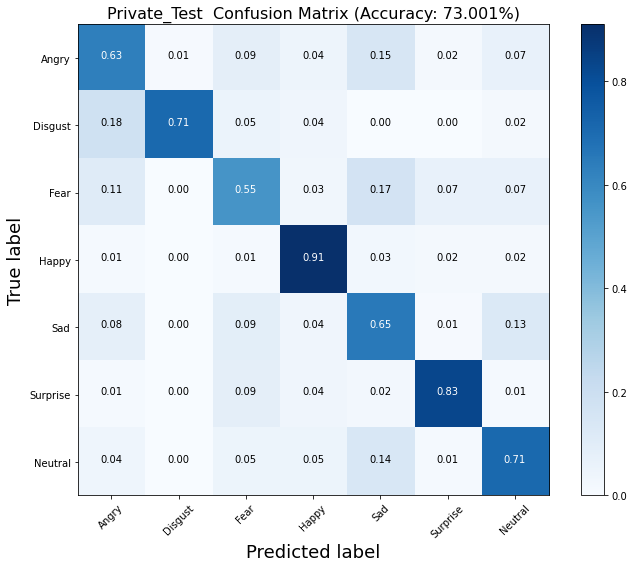

In [14]:
from sklearn.metrics import confusion_matrix
import itertools

cut_size = 44

transform_test = transforms.Compose([
    transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])
incorrect_examples = []
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Model
# net = resnet.ResNet18()

# path = os.path.join(opt.dataset + '_' + opt.model)
# checkpoint = torch.load(path_model)

# net.load_state_dict(checkpoint['net'])
# net.cuda()
saved_model.eval()
Testset = dataset.FER2013(split = "Private_Test", transform=transform_test, csv_file=BASE_PATH + '/' + FER2013_PATH_FILE_NAME)
Testloader = torch.utils.data.DataLoader(Testset, batch_size=1, shuffle=False, num_workers=1)
correct = 0
total = 0
all_target = []
for batch_idx, (inputs, targets) in enumerate(Testloader):
    # print('batch_idx: ', batch_idx)
    bs, ncrops, c, h, w = np.shape(inputs)
    inputs = inputs.view(-1, c, h, w)
    inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = Variable(inputs, volatile=True), Variable(targets)
    outputs = saved_model(inputs)

    outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops
    _, predicted = torch.max(outputs_avg.data, 1)

    total += targets.size(0)
    idxs_mask = ((predicted == targets) == False).nonzero()
    # print("idxs_mask: ", idxs_mask)
    # print(idxs_mask.size()[0])
    if(idxs_mask.size()[0] != 0):
        # print(inputs[idxs_mask].cpu().numpy().shape)
        # print(emotion_labels[predicted])
        # print(targets)
        incorrect_examples.append(incorrectoutcome(inputs[idxs_mask].cpu().numpy(), emotion_labels[targets], emotion_labels[predicted],  batch_idx))   
    
    correct += predicted.eq(targets.data).cpu().sum()
    if batch_idx == 0:
        all_predicted = predicted
        all_targets = targets
    else:
        all_predicted = torch.cat((all_predicted, predicted),0)
        all_targets = torch.cat((all_targets, targets),0)

acc = 100. * correct / total
print("accuracy: %0.3f" % acc)

# Compute confusion matrix
matrix = confusion_matrix(all_targets.data.cpu().numpy(), all_predicted.cpu().numpy())
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(matrix, classes=class_names, normalize=True,
                      title= "Private_Test "+' Confusion Matrix (Accuracy: %0.3f%%)' %acc)
plt.show()
# plt.savefig(os.path.join(path, "Private_Test" + '_cm.png'))
# plt.close()

In [17]:
len(incorrect_examples)

# incorrect_examples[0].shape

969

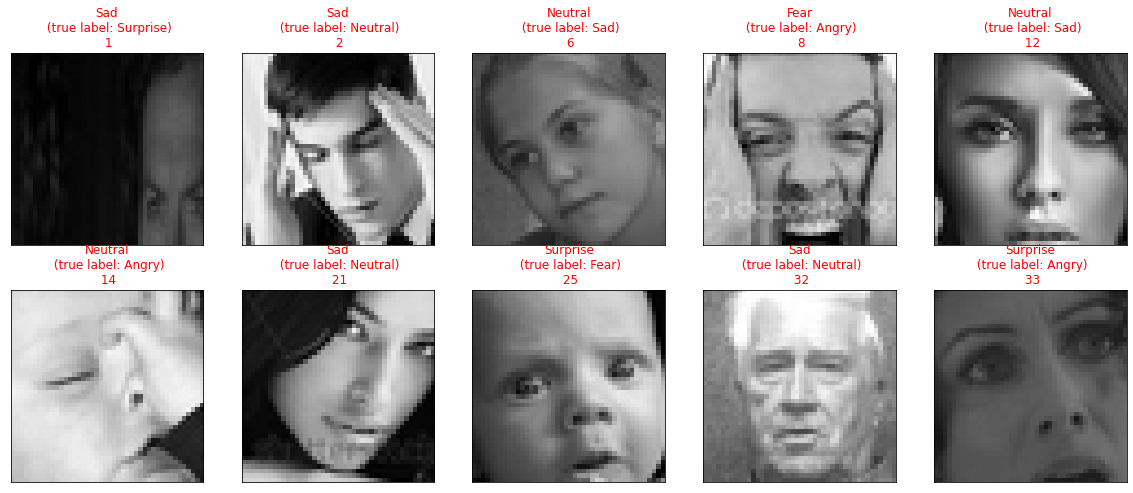

In [18]:

fig = plt.figure(figsize=(20, 8))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    #std = np.array([0.229, 0.224, 0.225])
    #mean = np.array([0.485, 0.456, 0.406])
    incorrectoutcome = incorrect_examples[idx]
    img = incorrectoutcome.img
    # print(img.shape)
    img = np.transpose(img, (3, 4, 0, 1, 2))
    # print(img.shape)
    img = img[:, :, 0, 0, 0]
    img2 = np.zeros((44,44,3))
    img2[:,:,0] = img
    img2[:,:,1] = img
    img2[:,:,2] = img
    plt.imshow(img2)
    ax.set_title(f"{incorrectoutcome.predictedLabel}\n (true label: {incorrectoutcome.trueLabel})\n {incorrectoutcome.indexInDataset}",
    color=("green" if incorrectoutcome.predictedLabel==incorrectoutcome.trueLabel else "red"))

Total convolutional layers: 18
torch.Size([3, 44, 44])


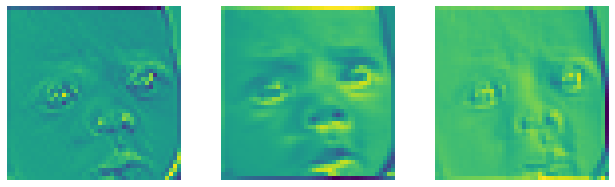

torch.Size([64, 44, 44])


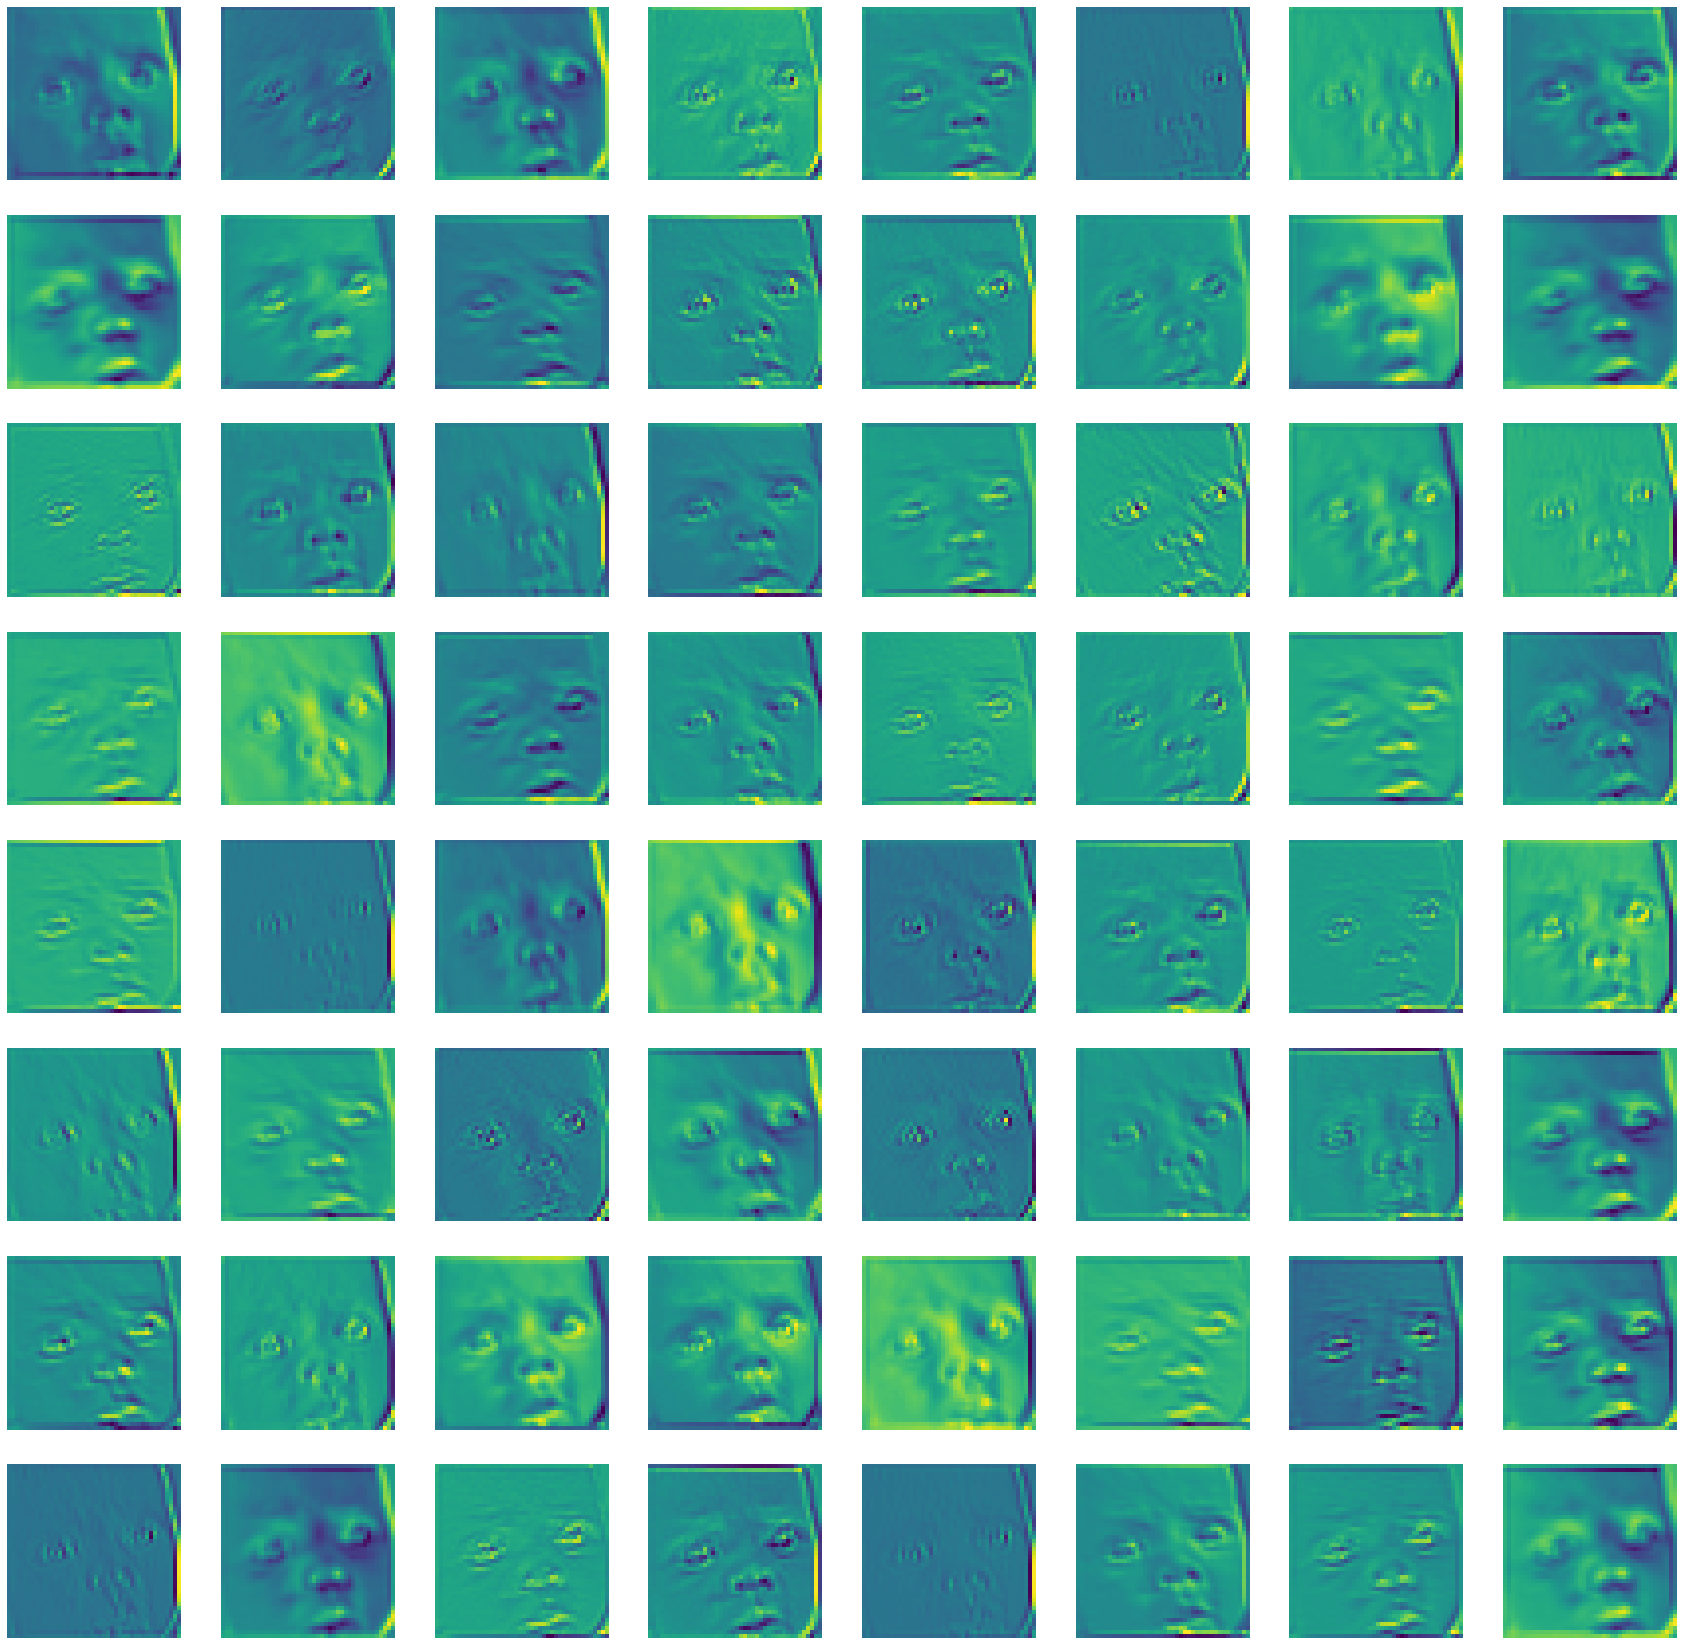

torch.Size([64, 44, 44])


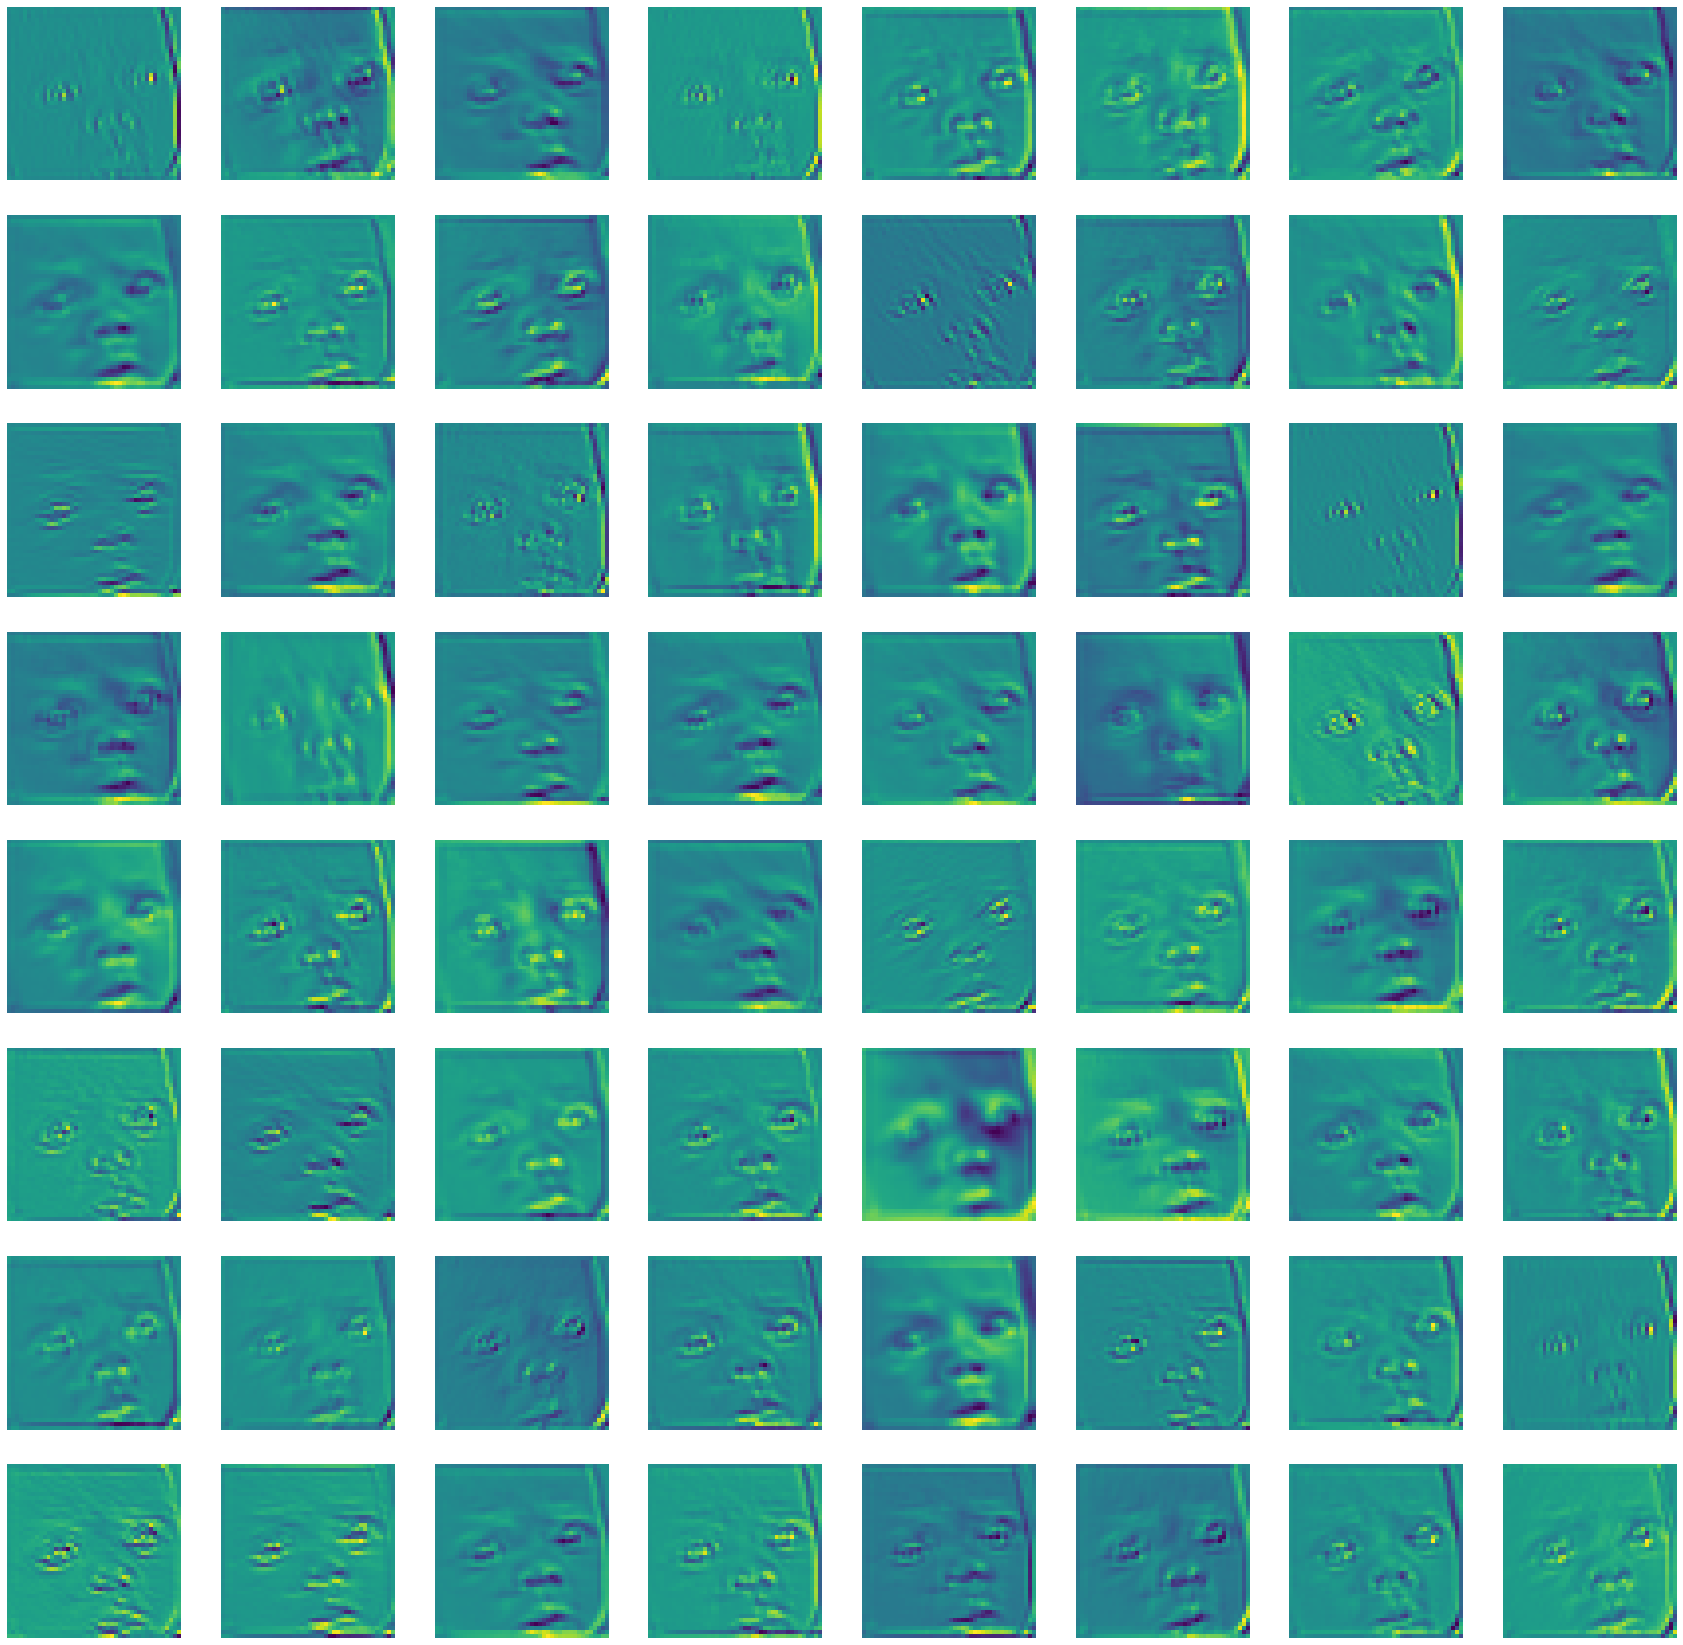

torch.Size([64, 44, 44])


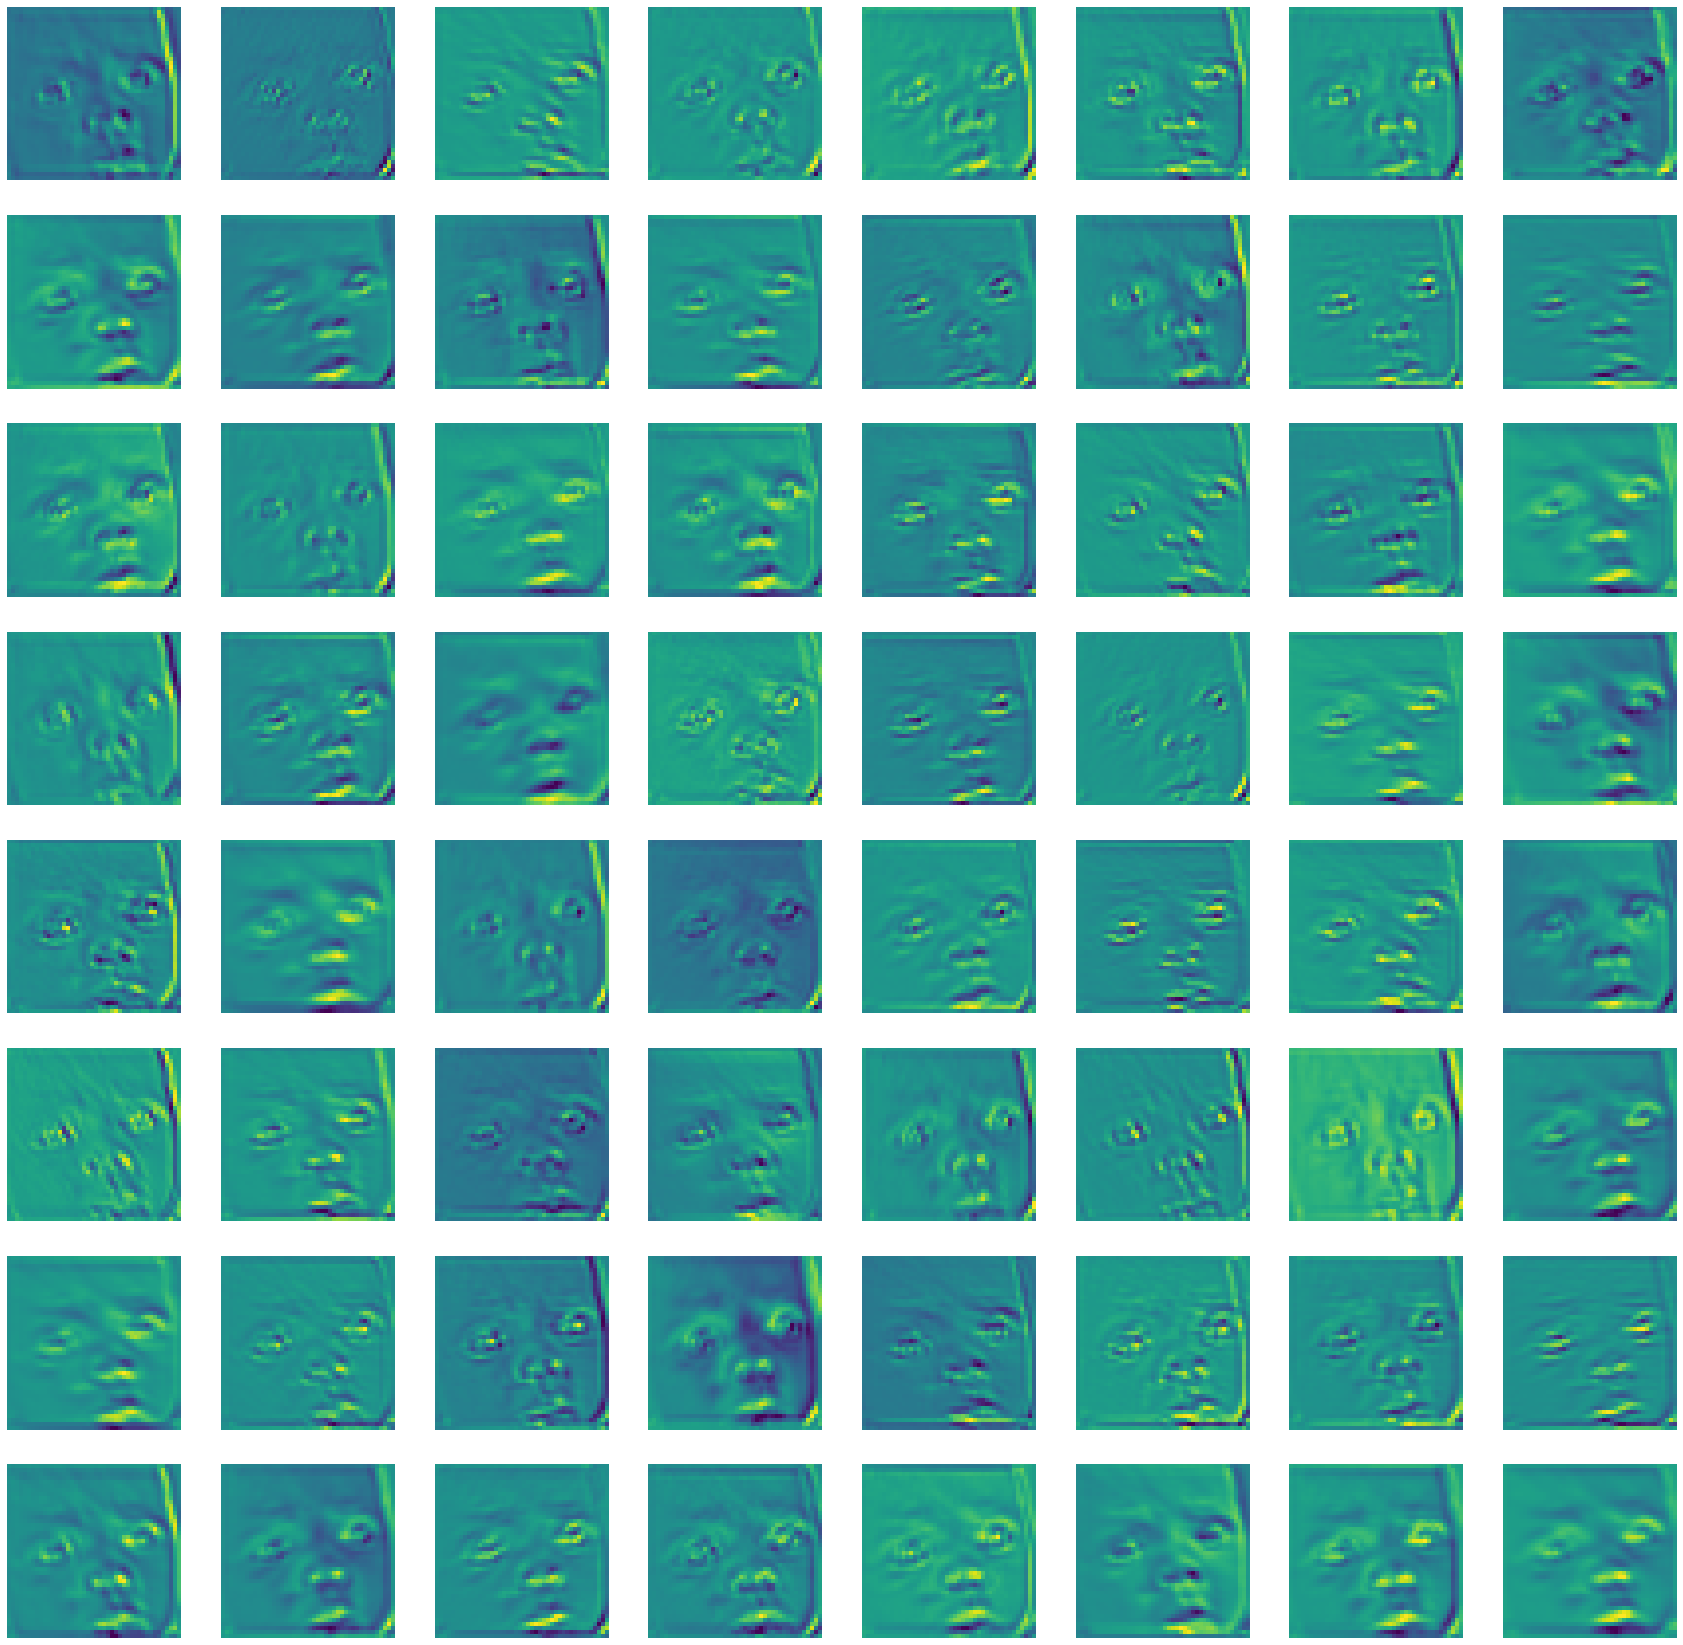

torch.Size([64, 44, 44])


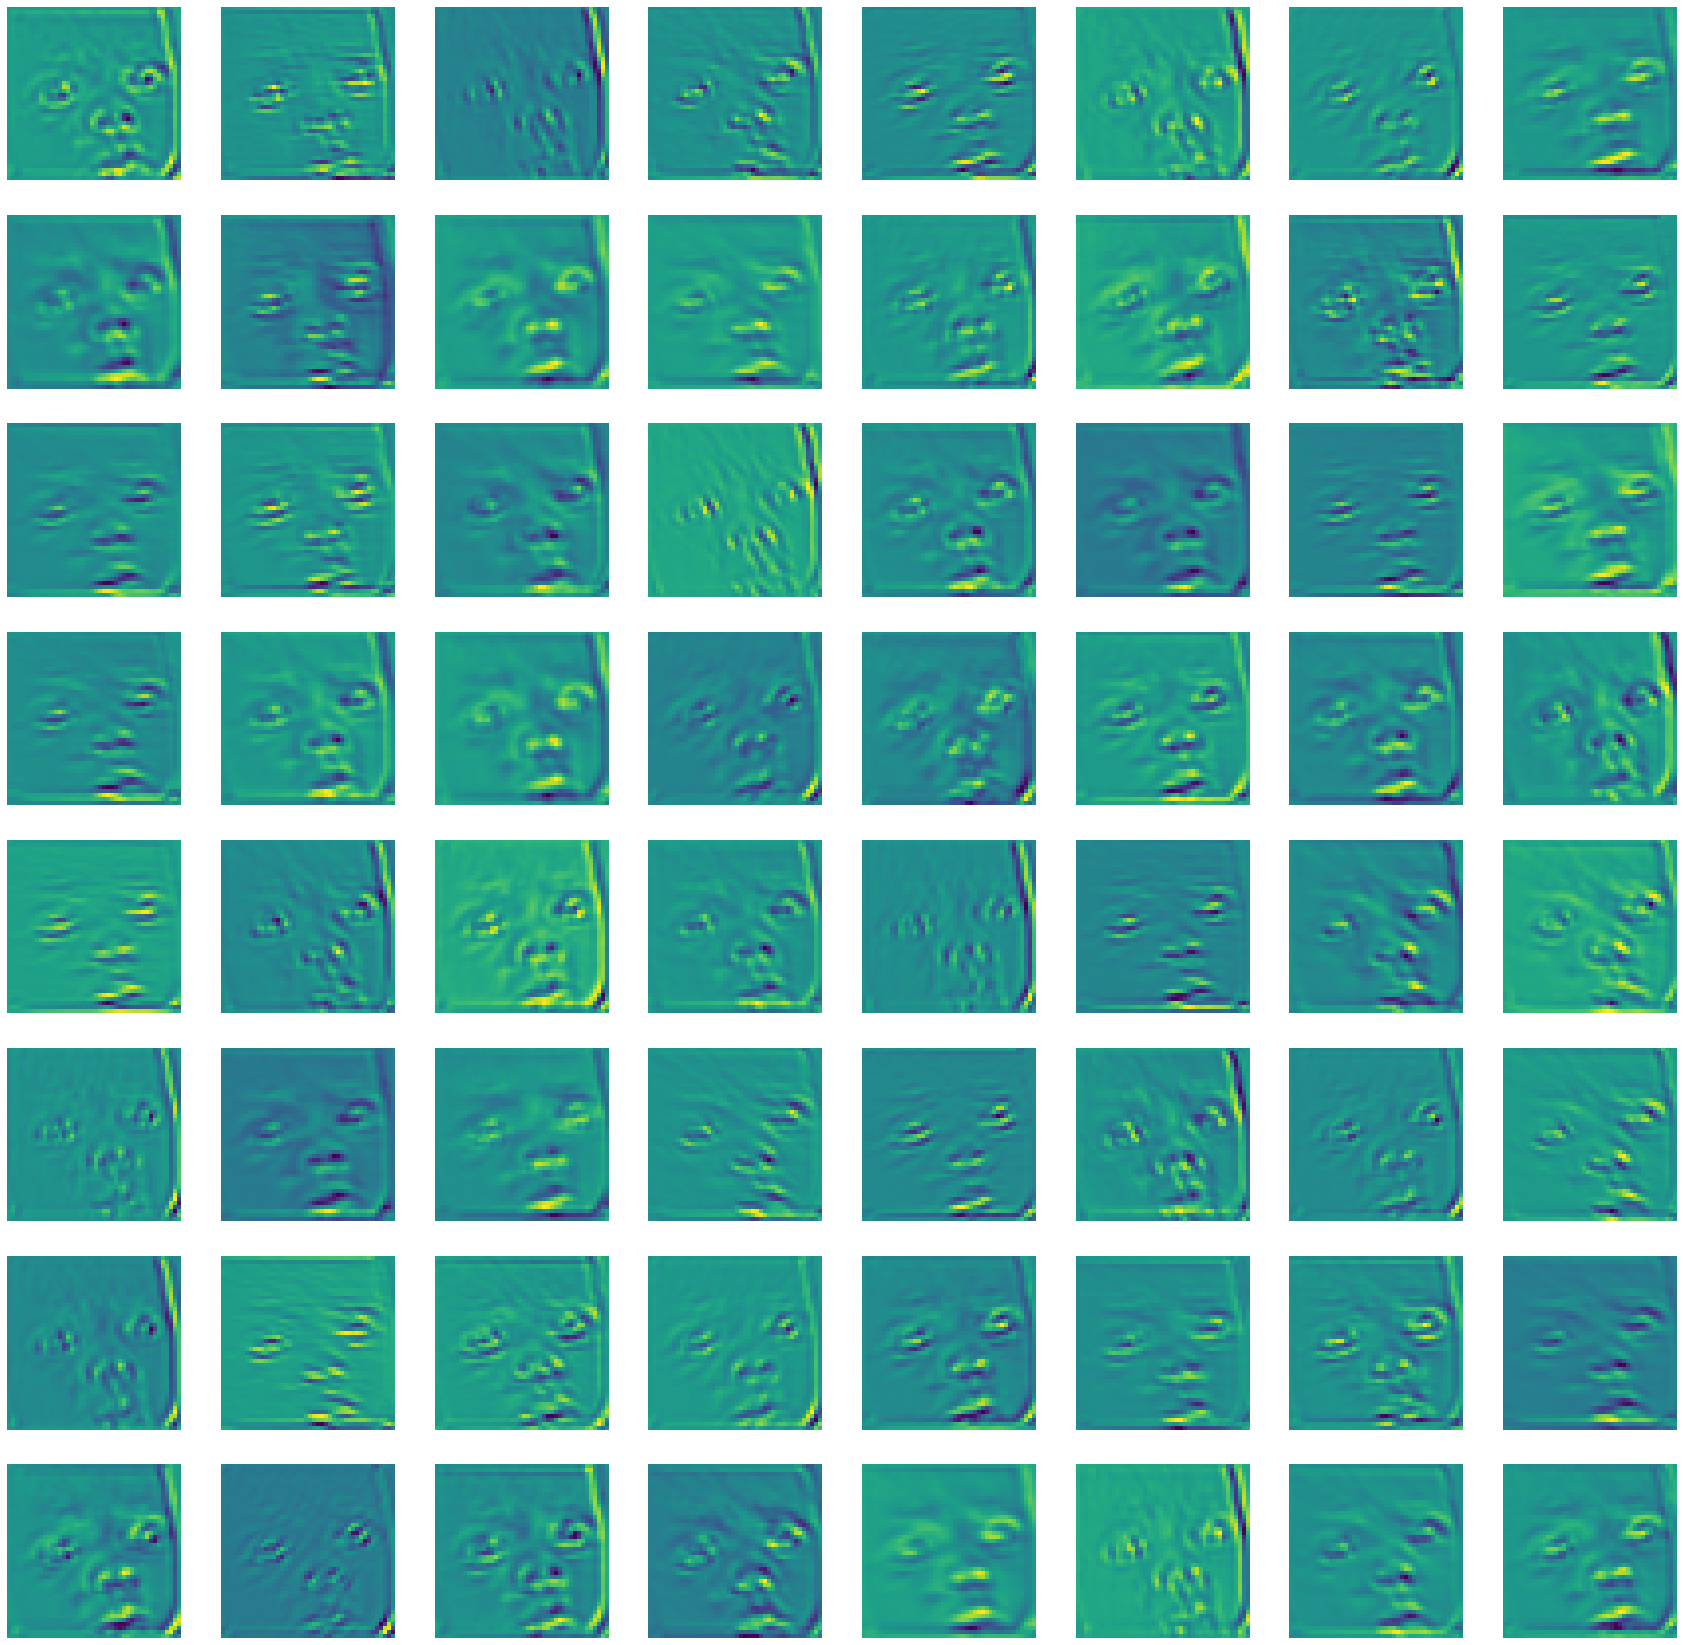

torch.Size([64, 44, 44])


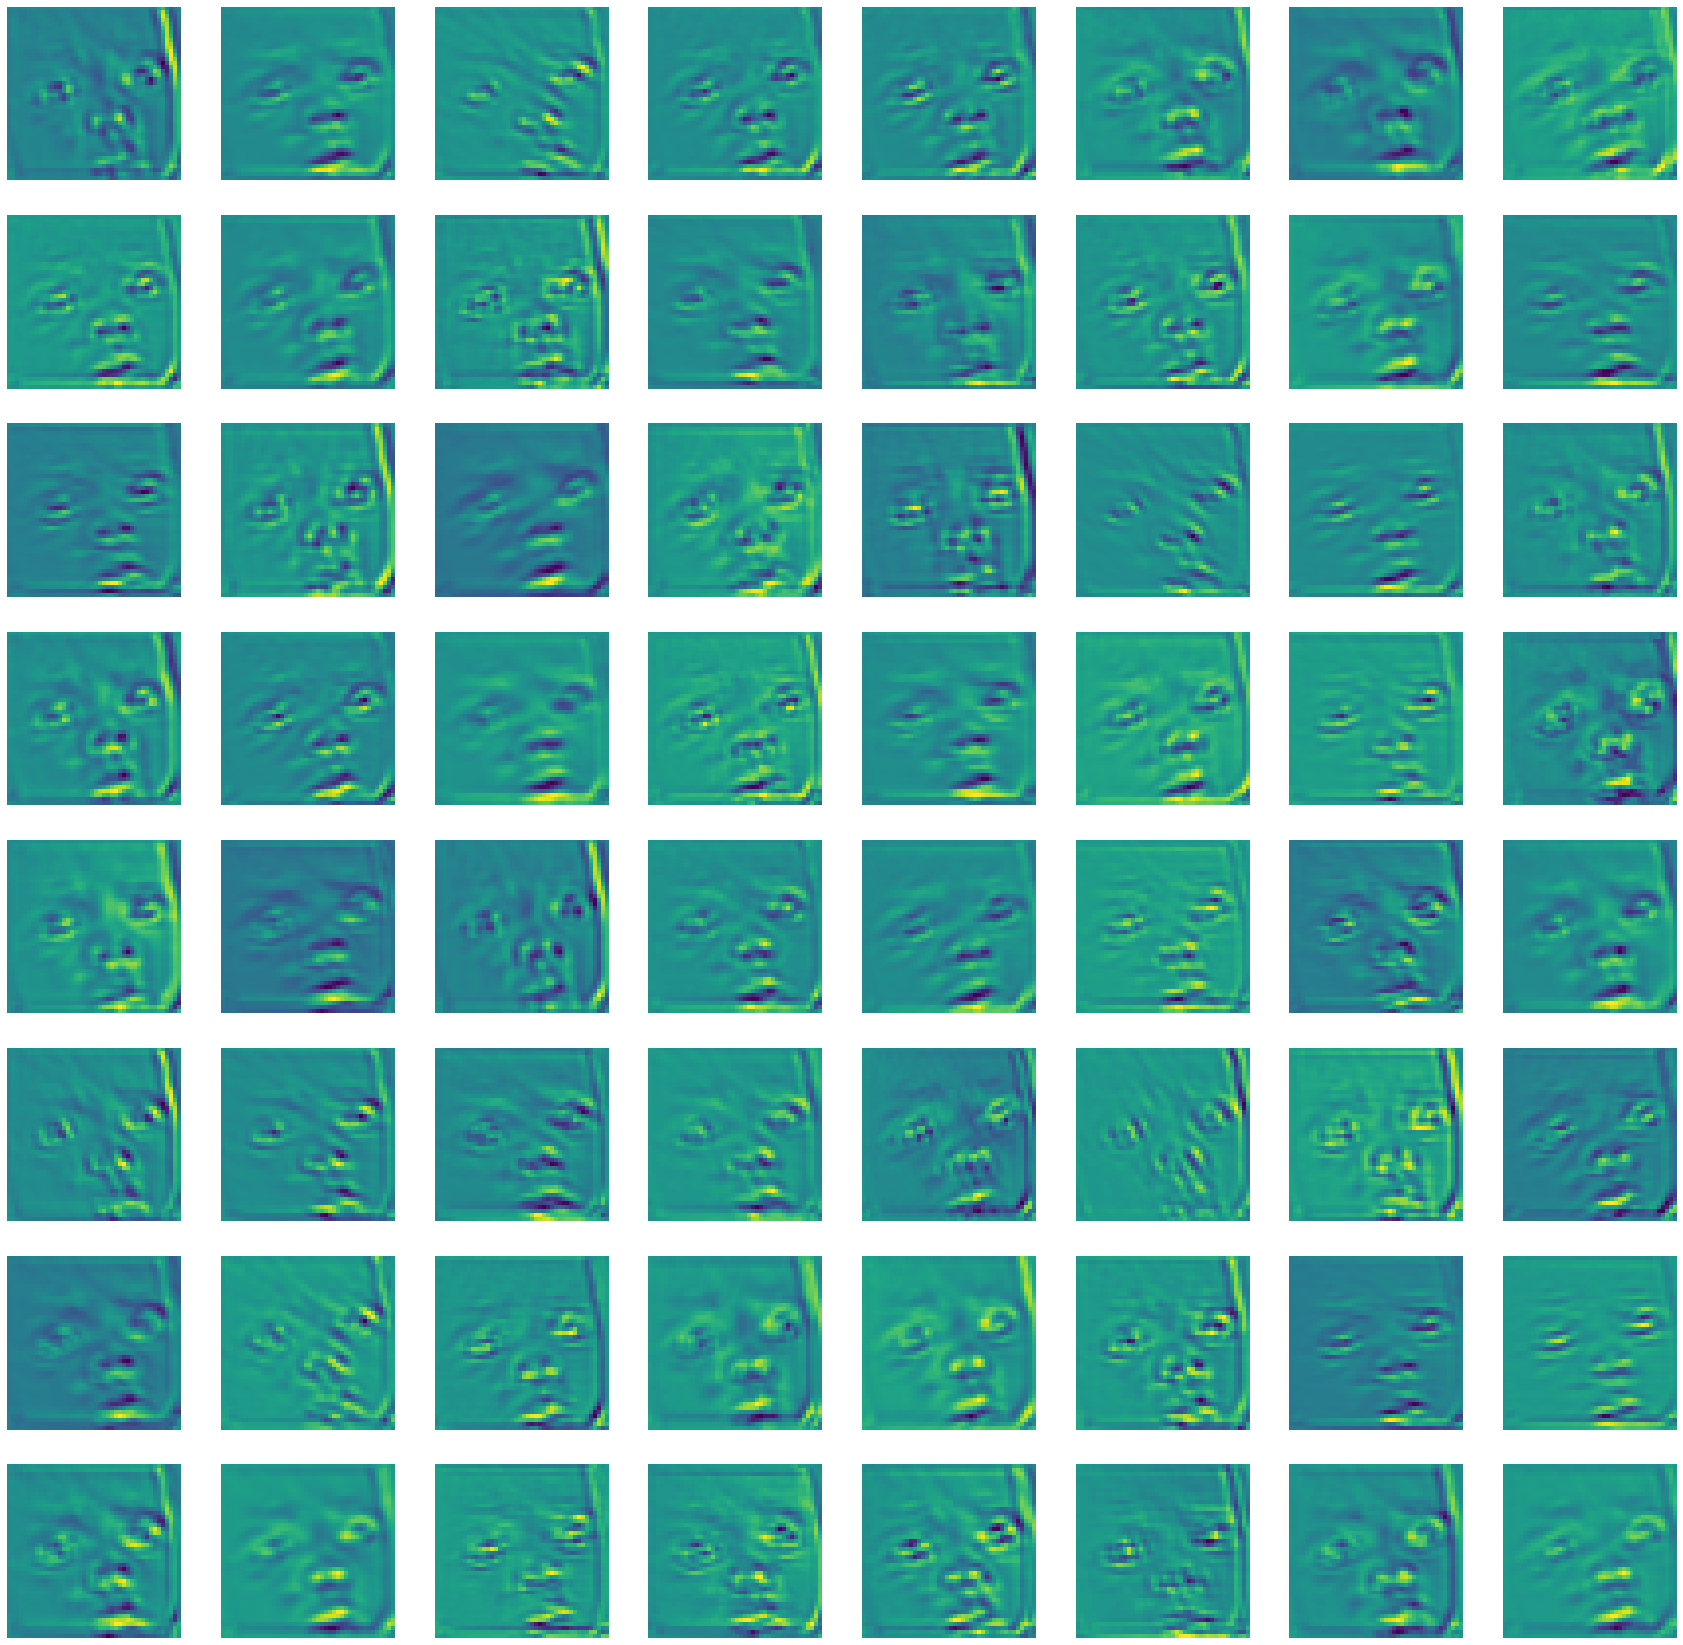

torch.Size([128, 22, 22])


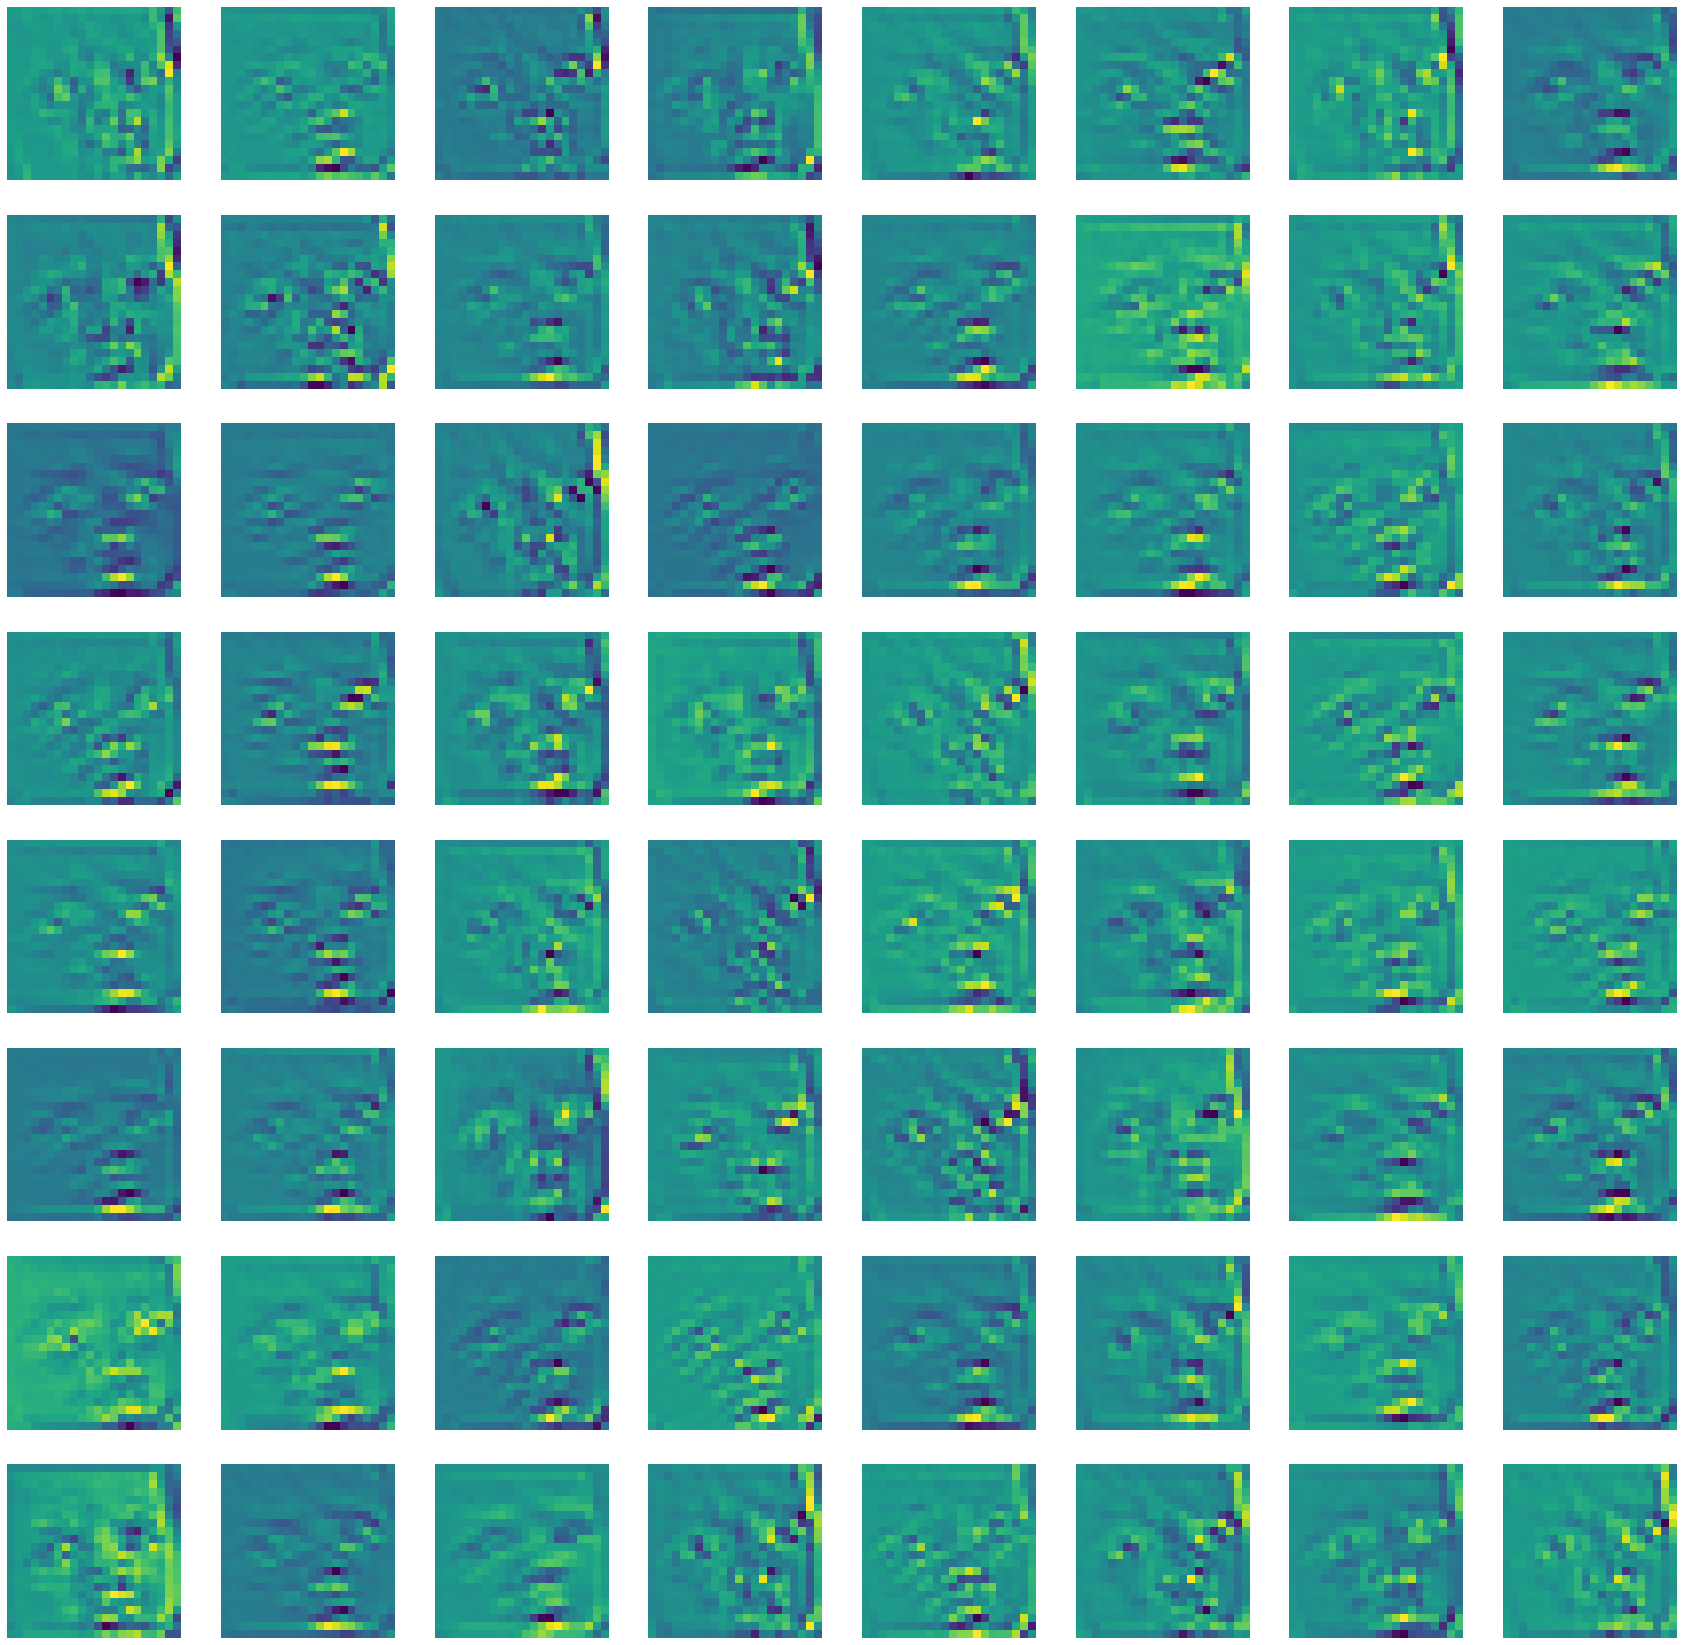

torch.Size([128, 22, 22])


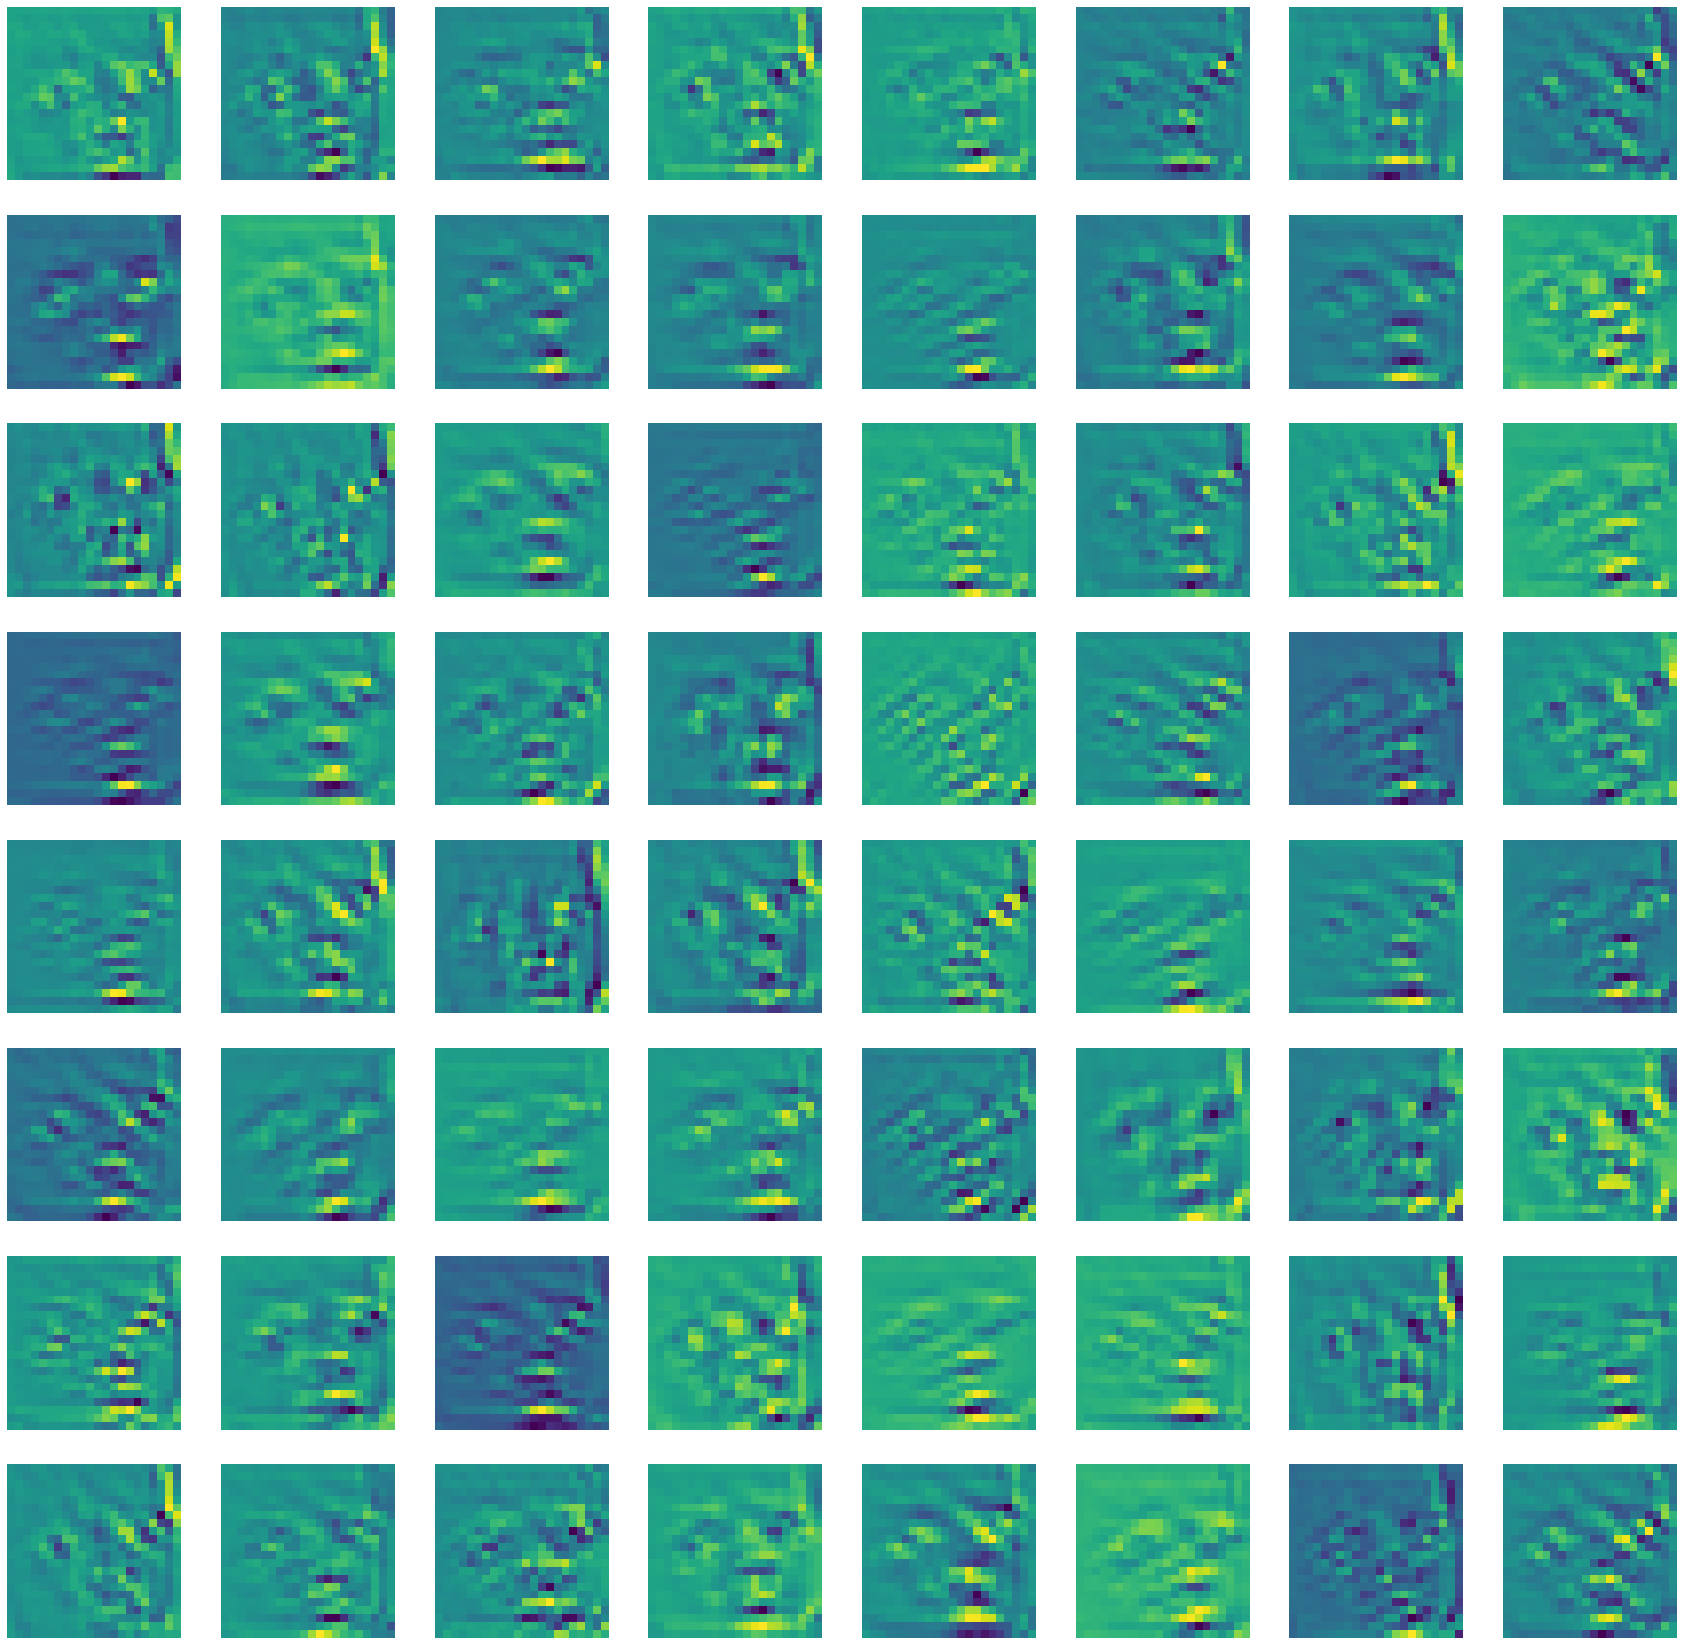

torch.Size([128, 22, 22])


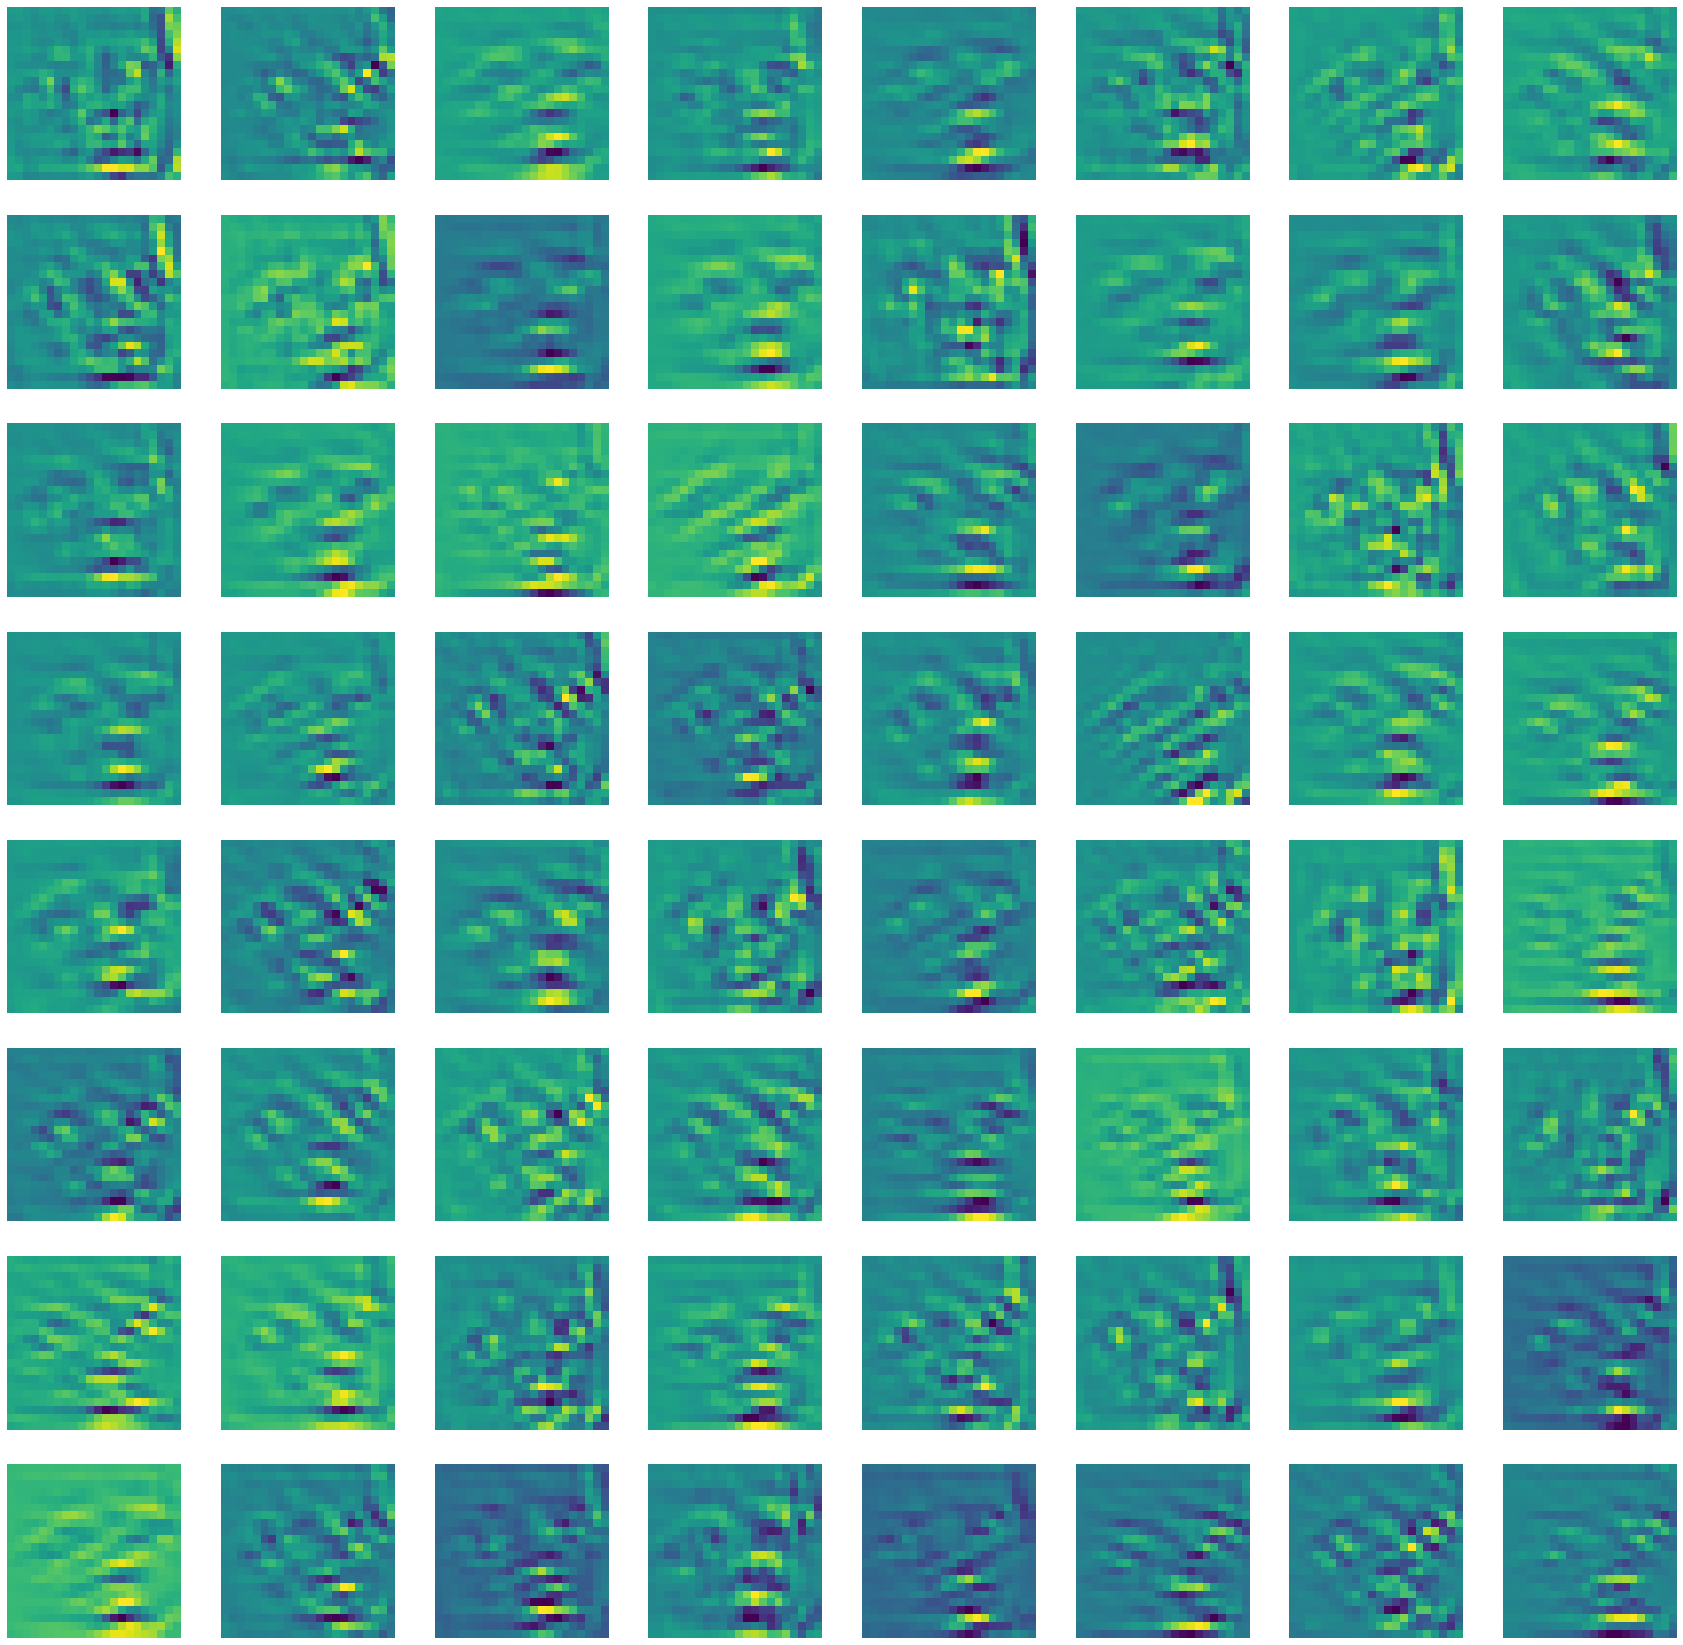

torch.Size([128, 22, 22])


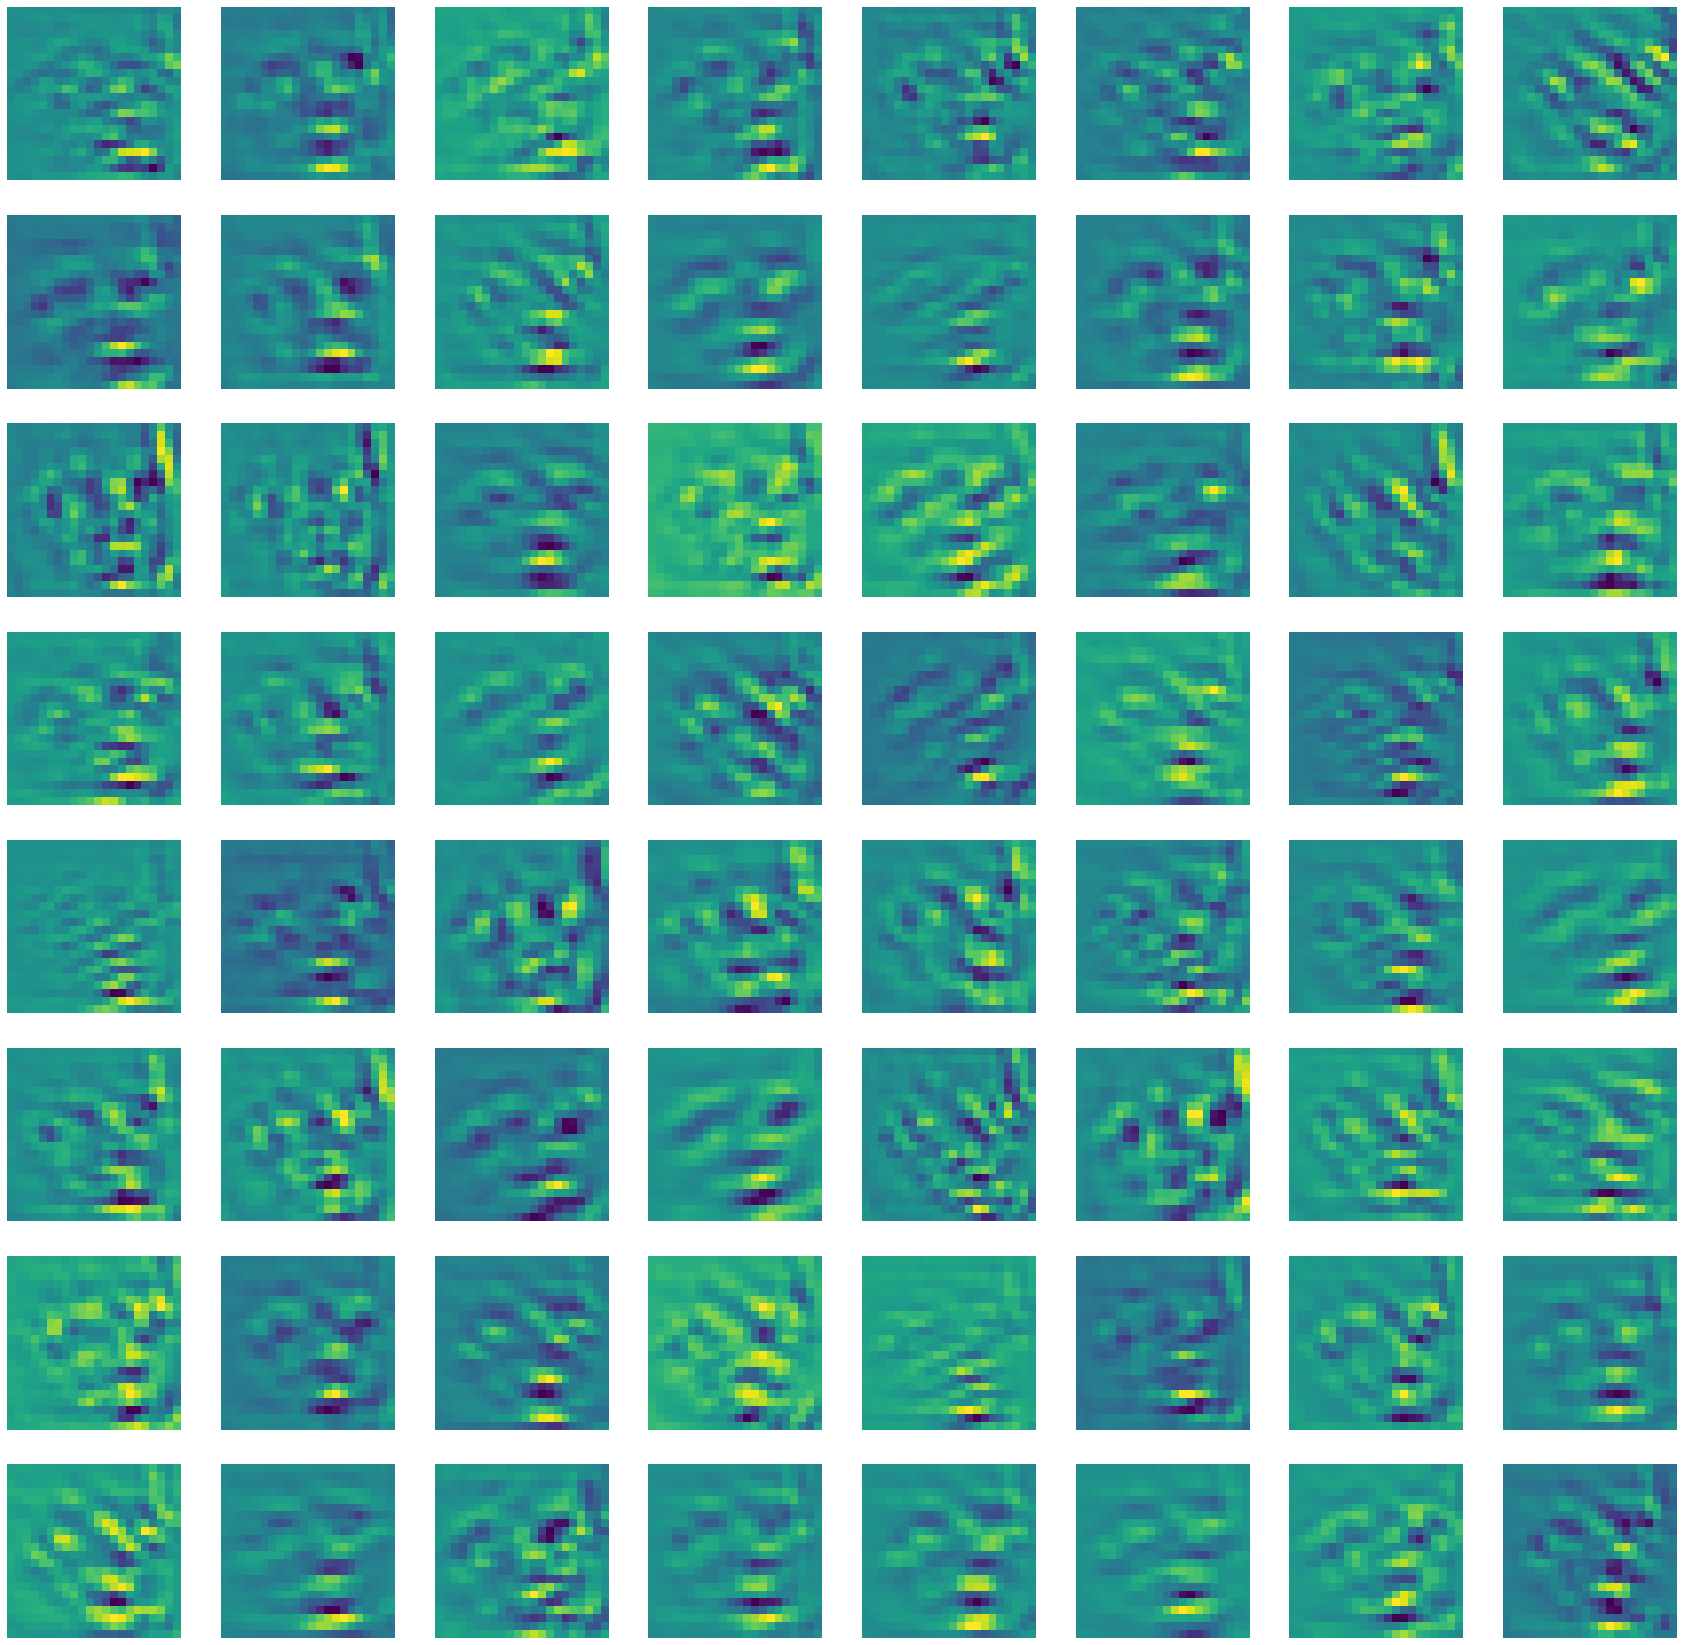

torch.Size([256, 11, 11])


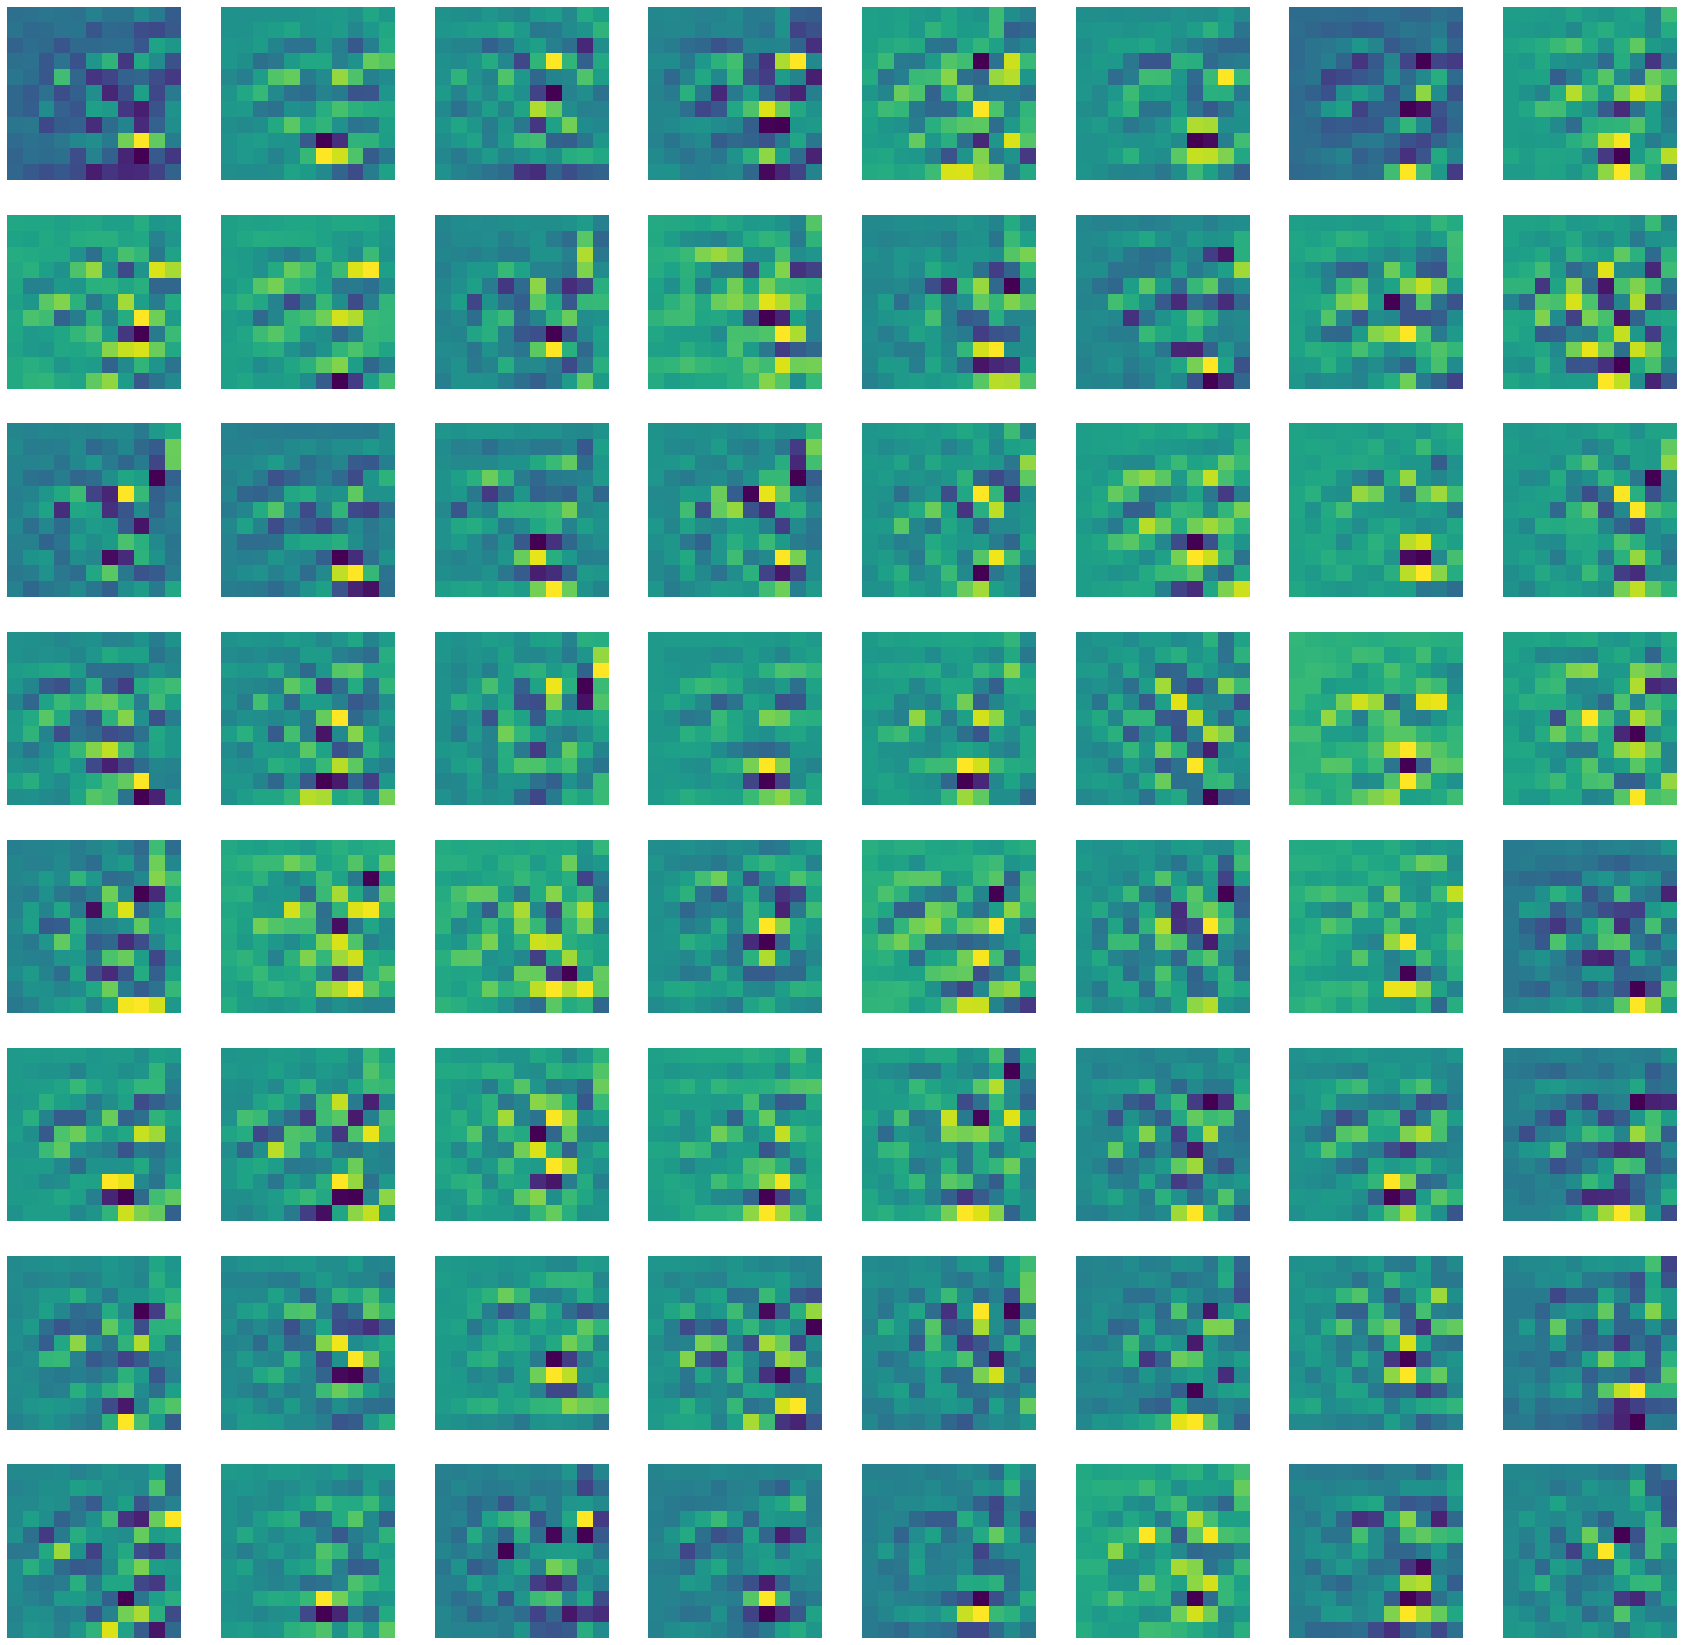

torch.Size([256, 11, 11])


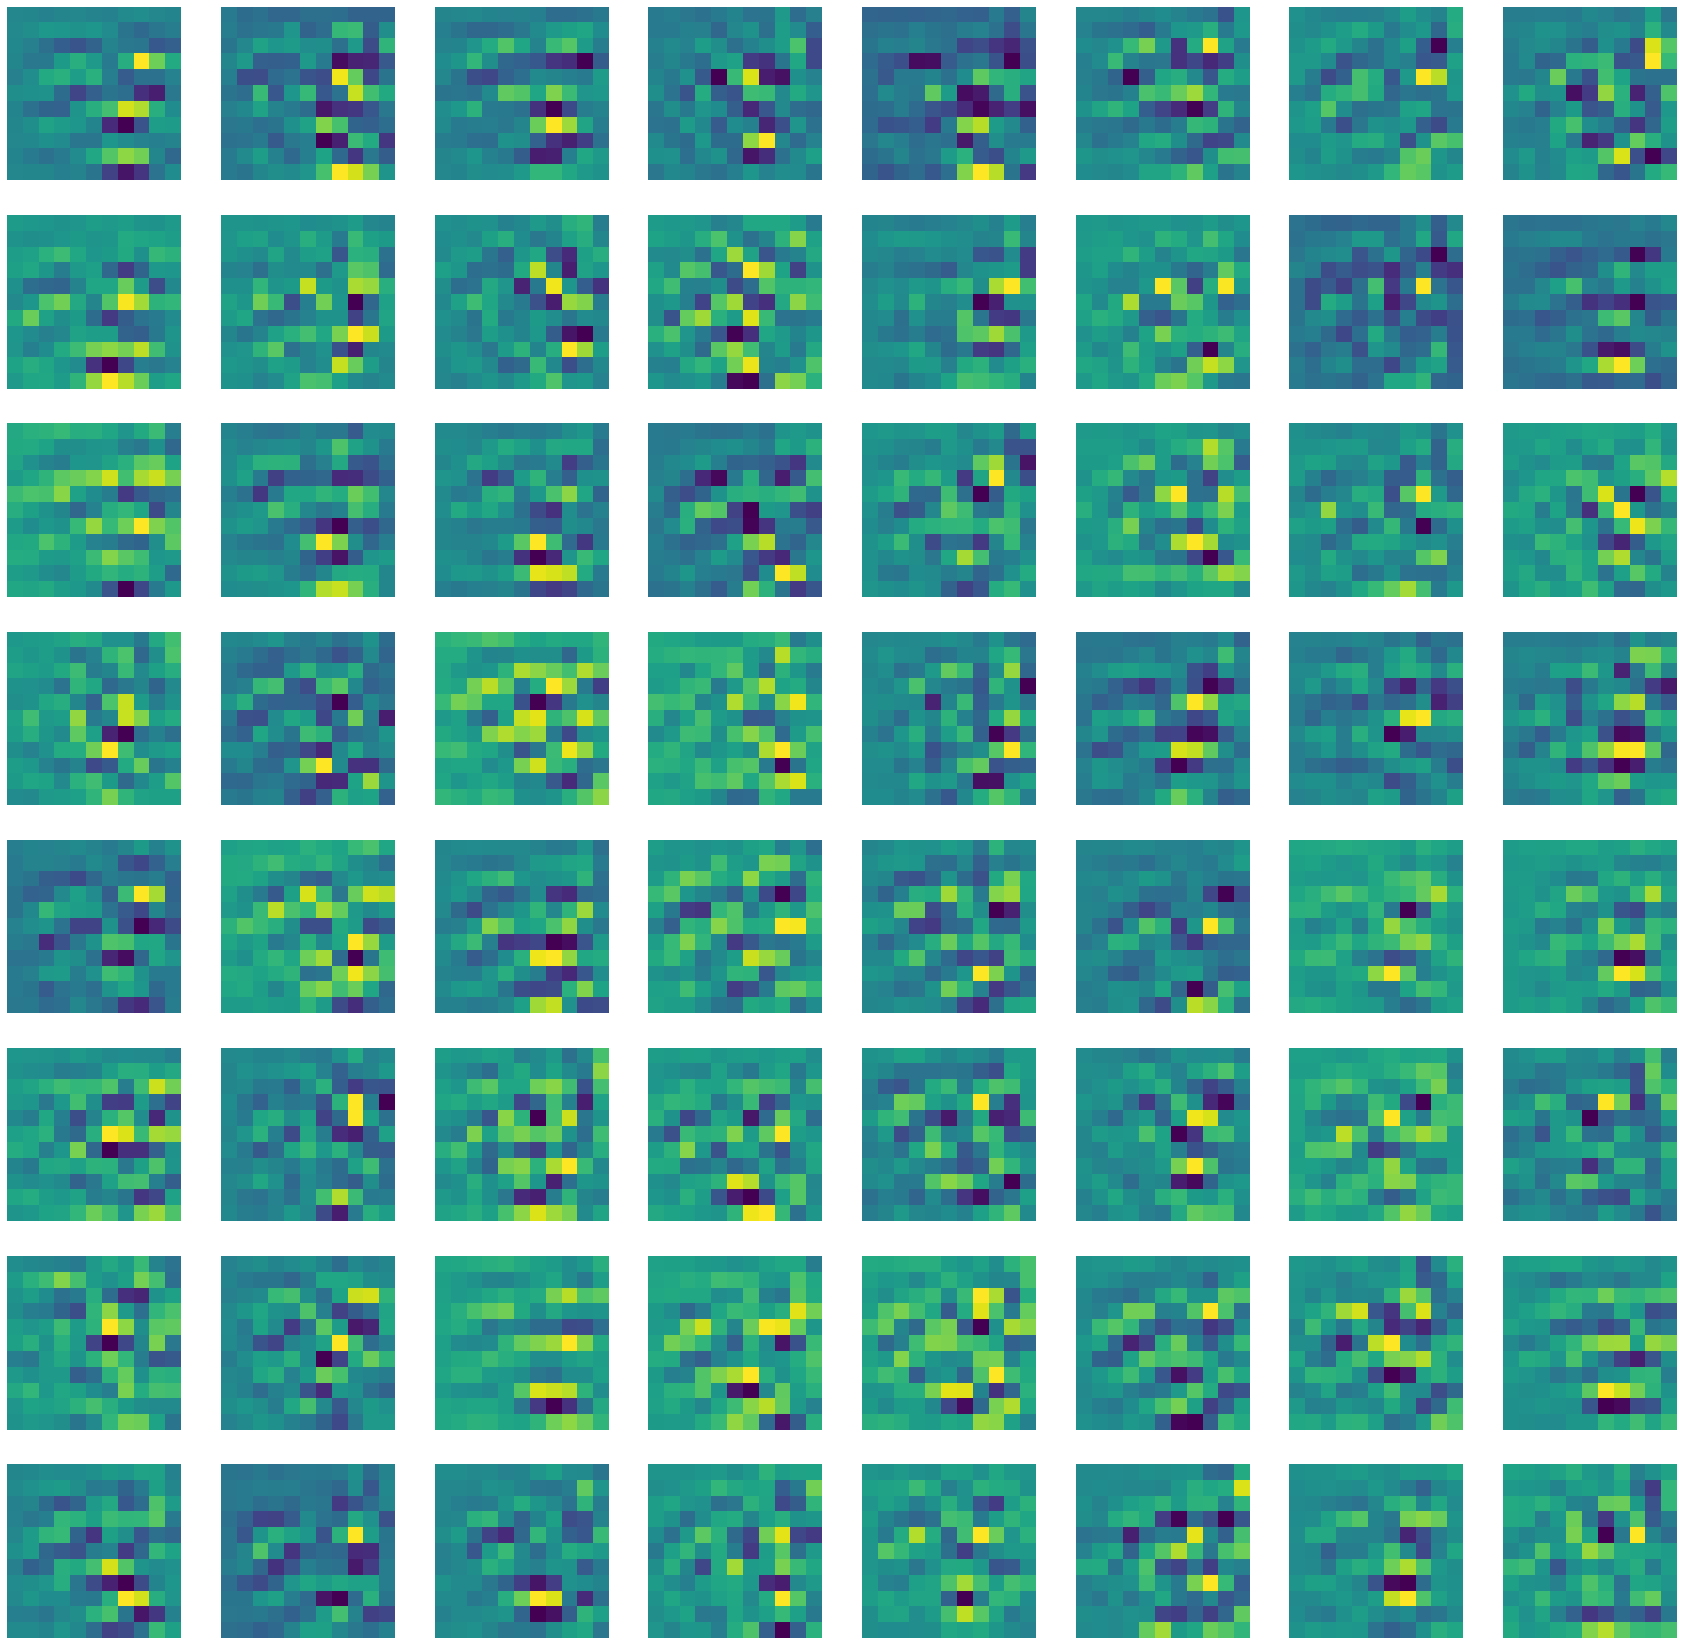

torch.Size([256, 11, 11])


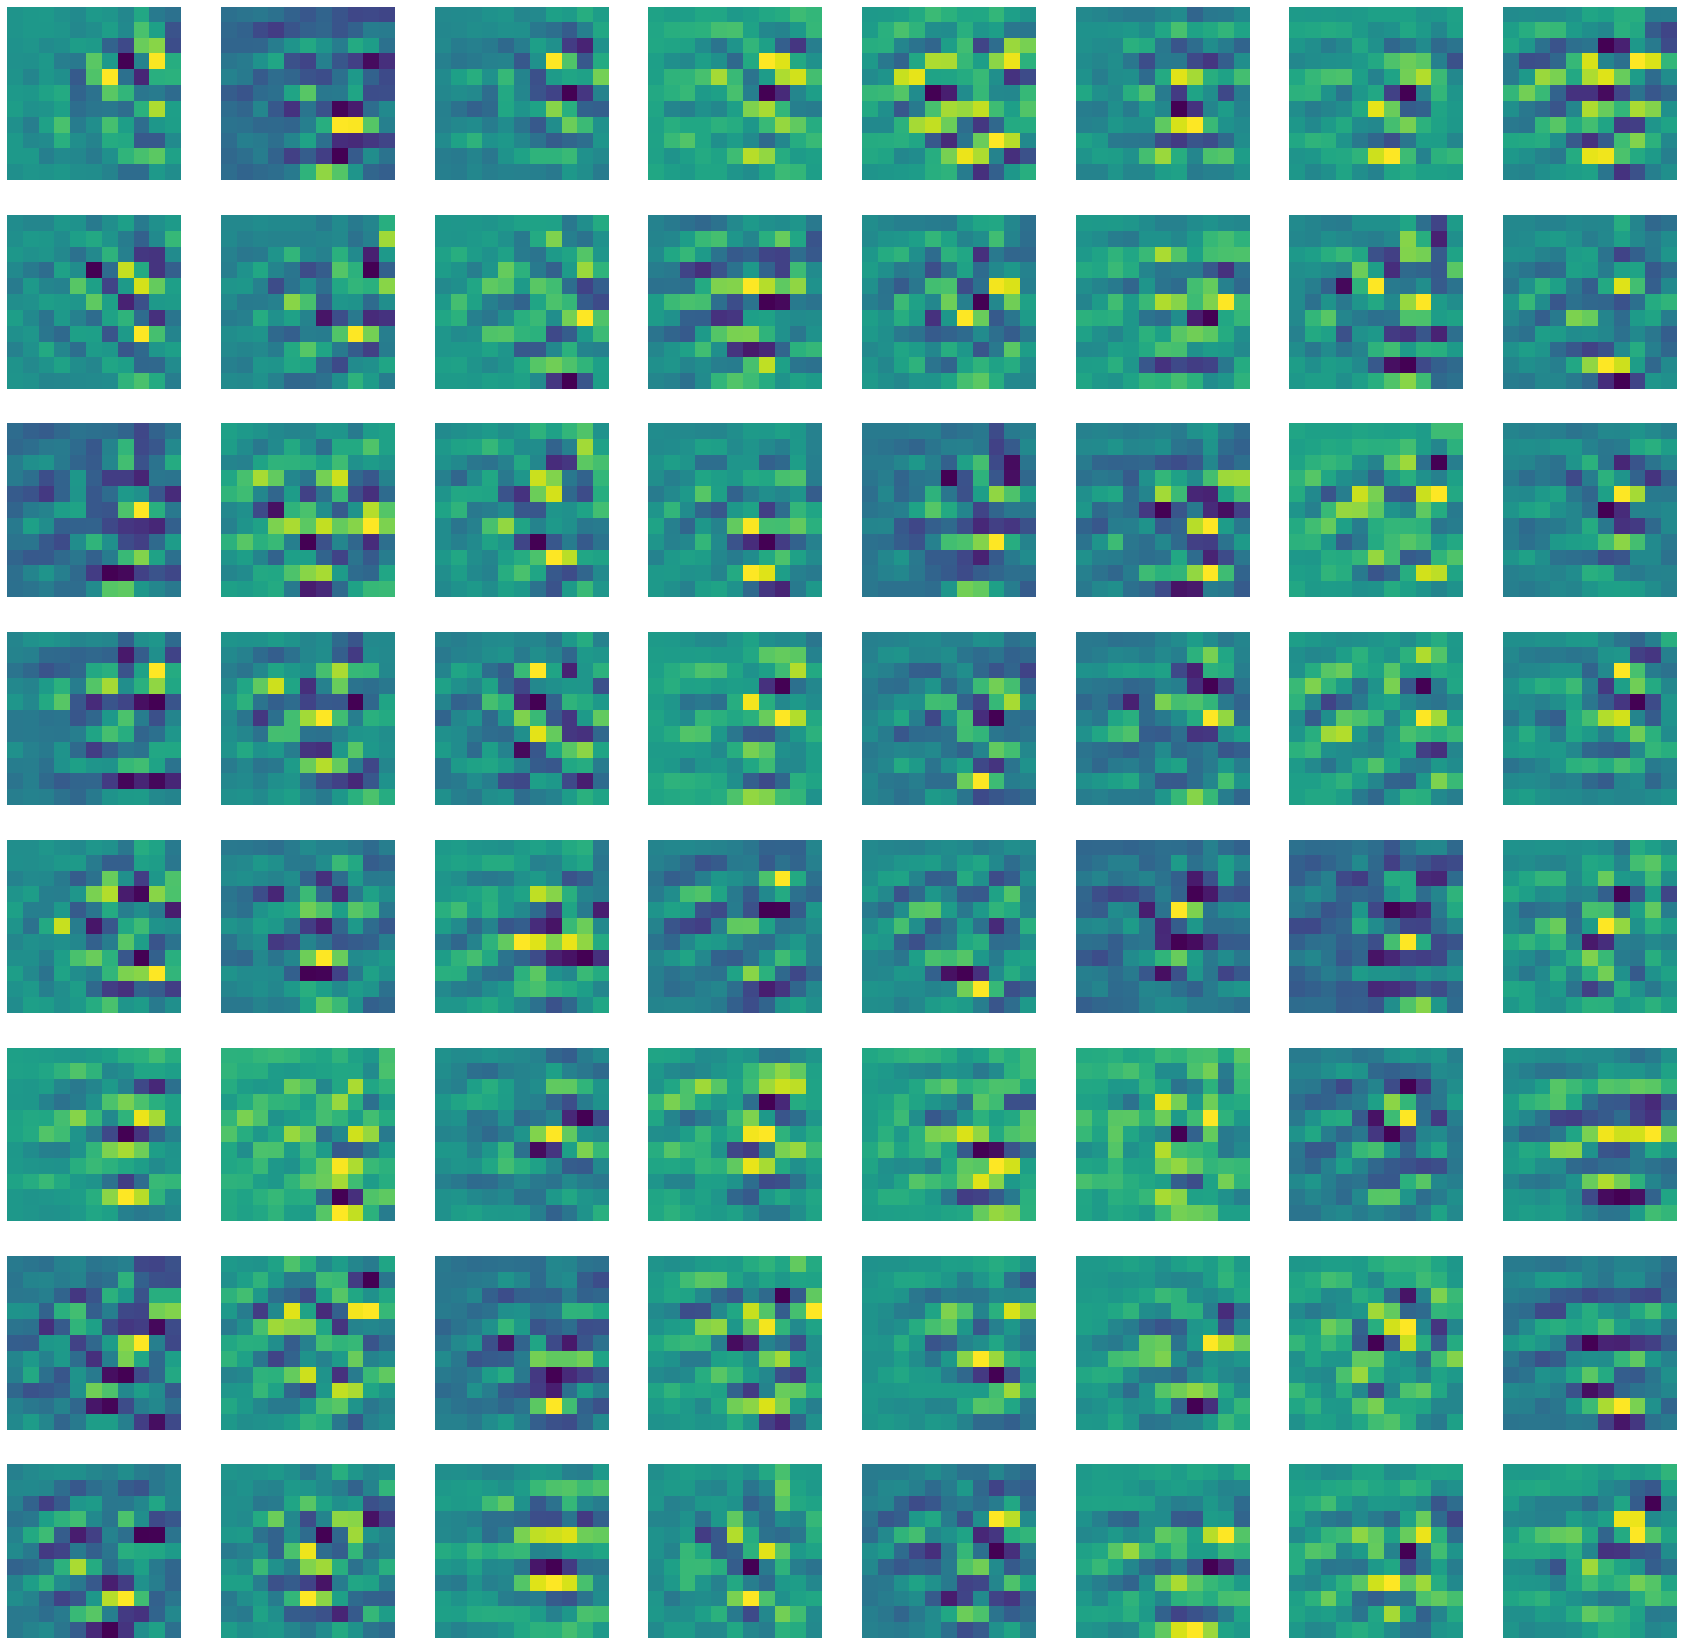

torch.Size([256, 11, 11])


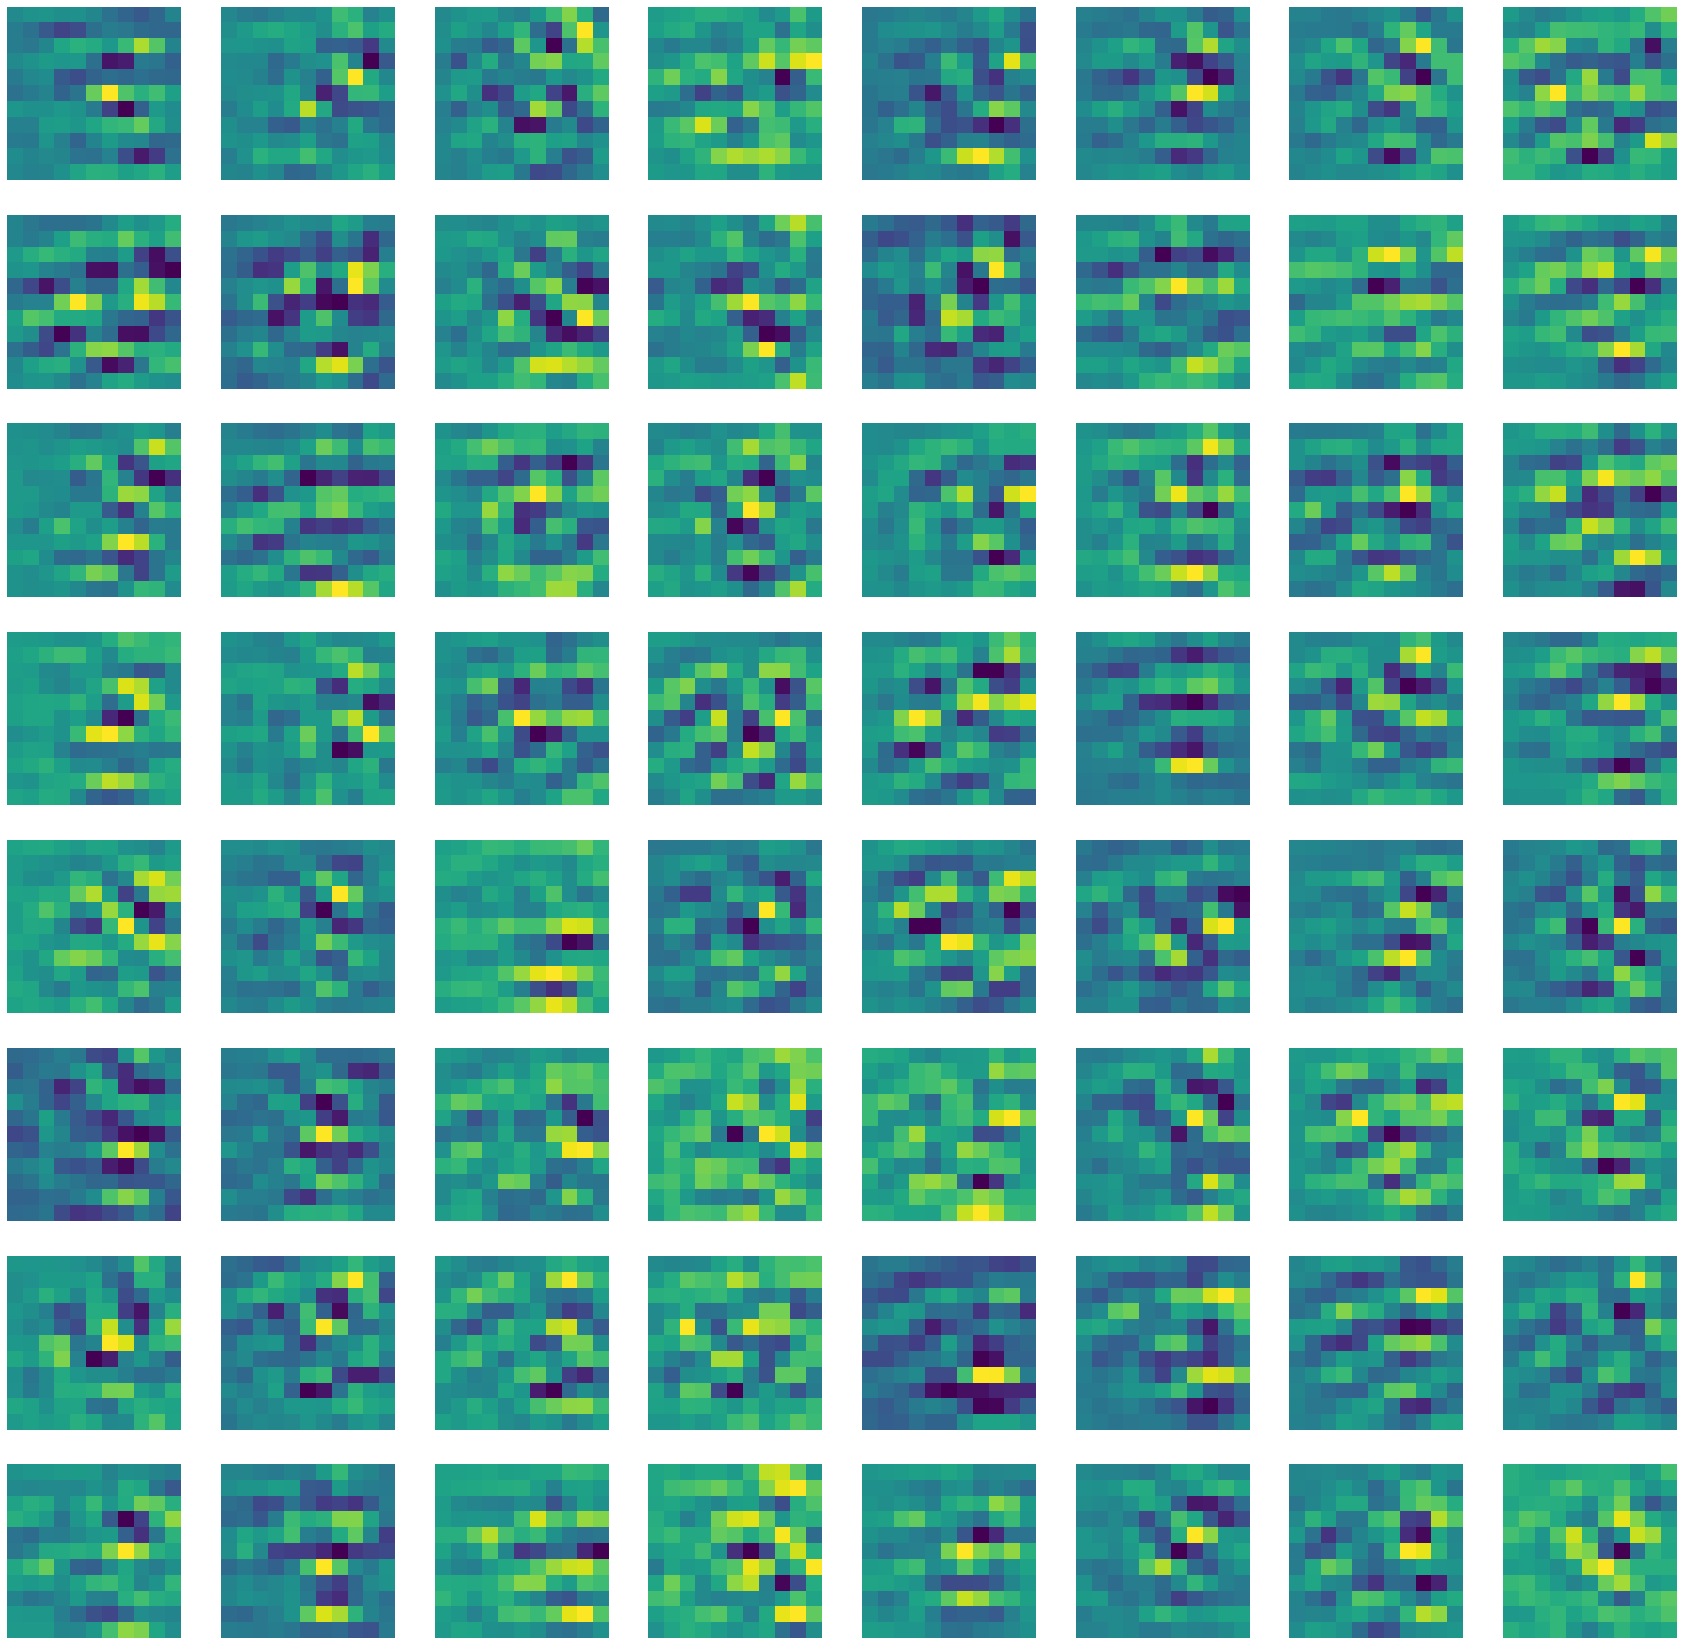

torch.Size([512, 6, 6])


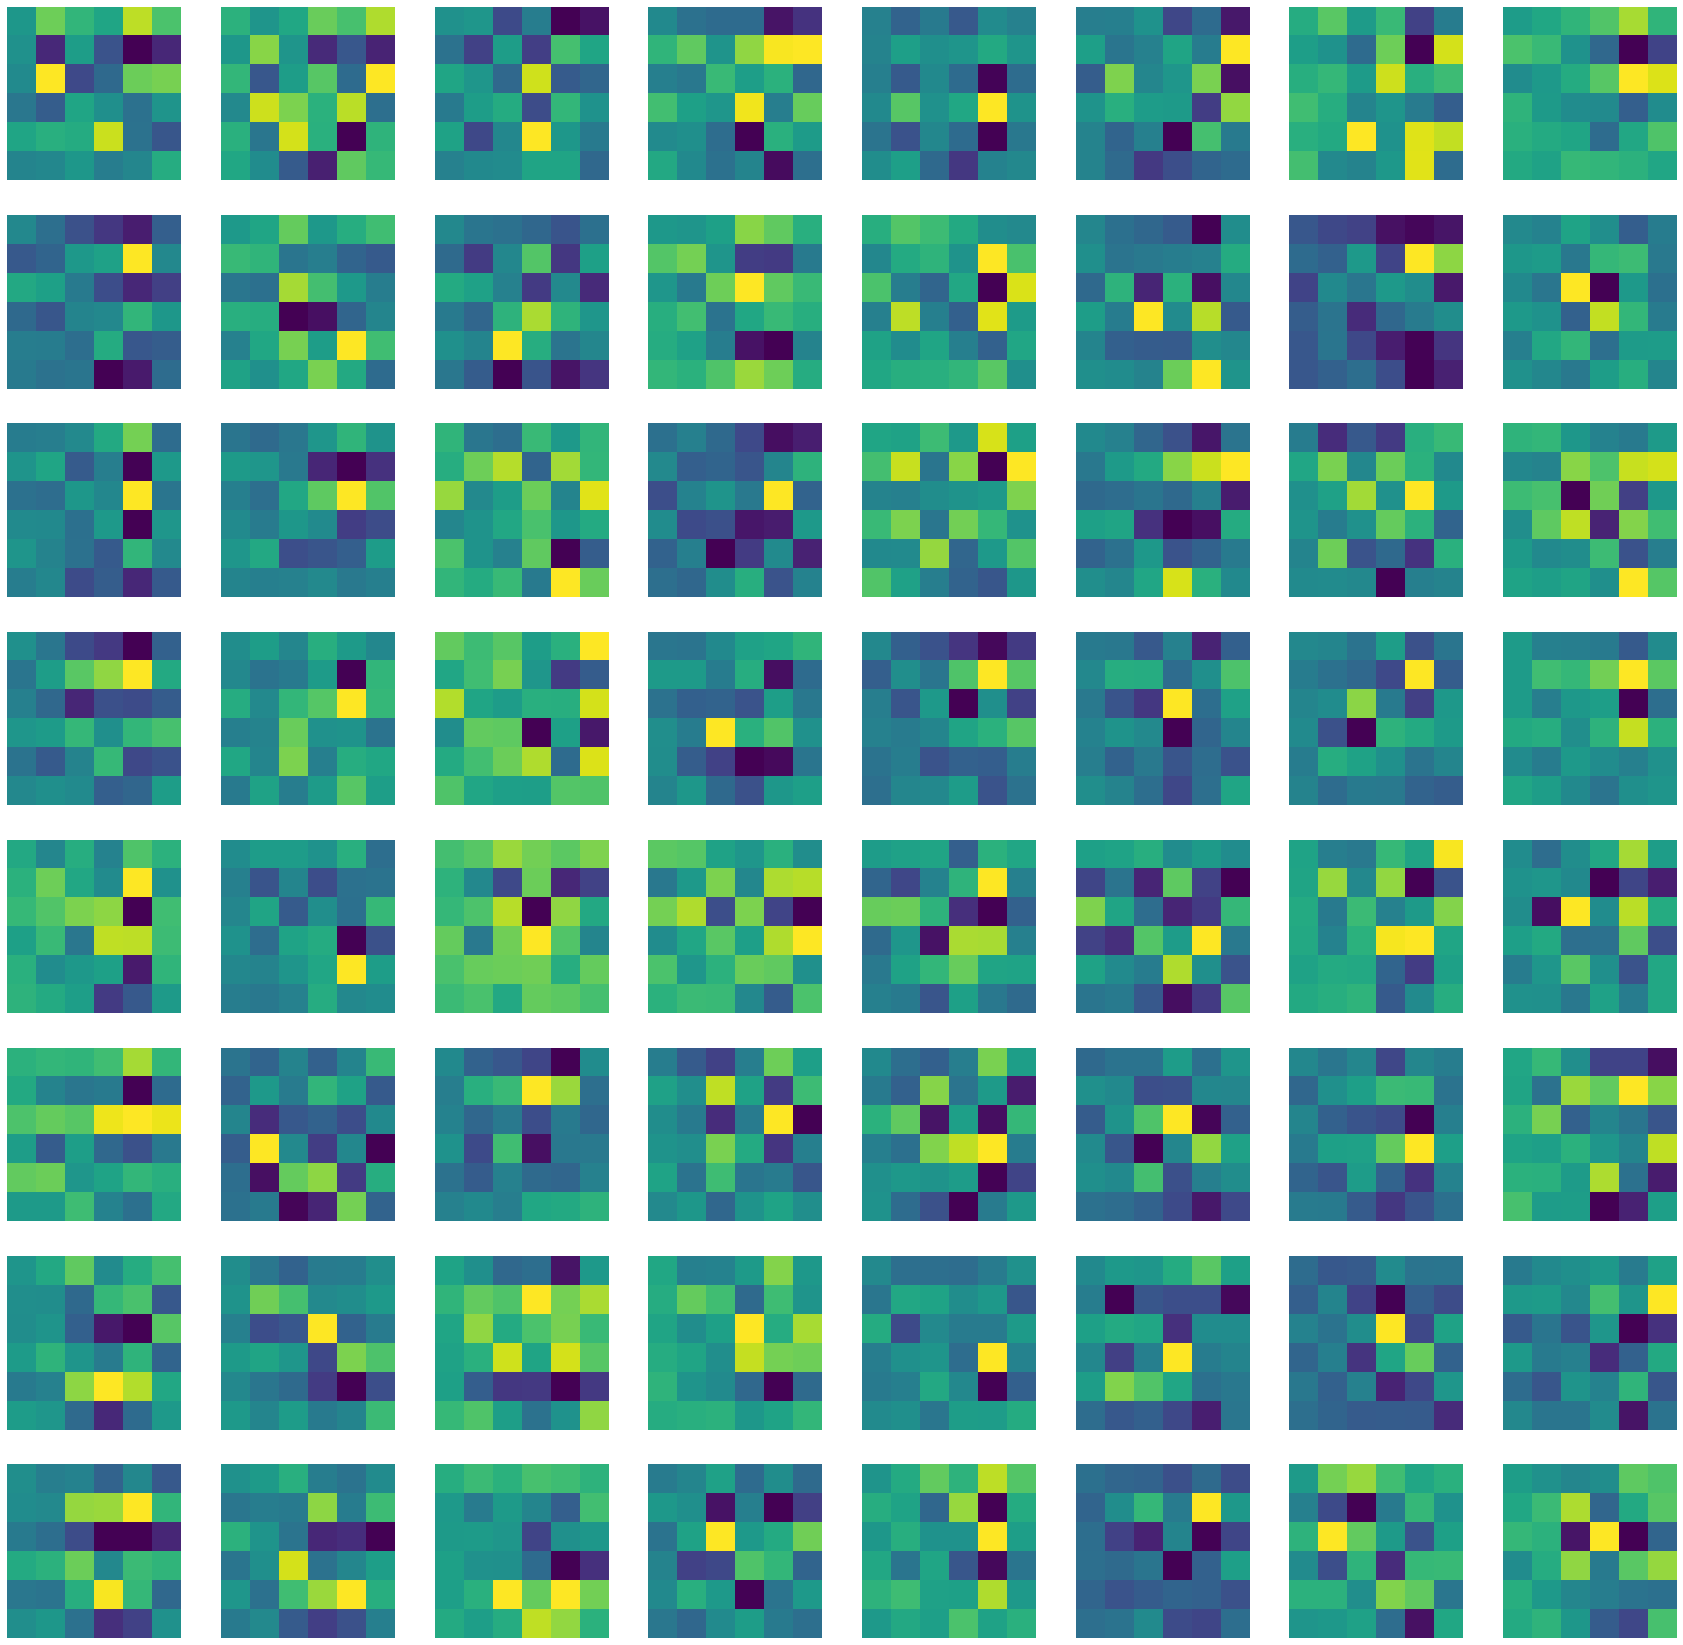

torch.Size([512, 6, 6])


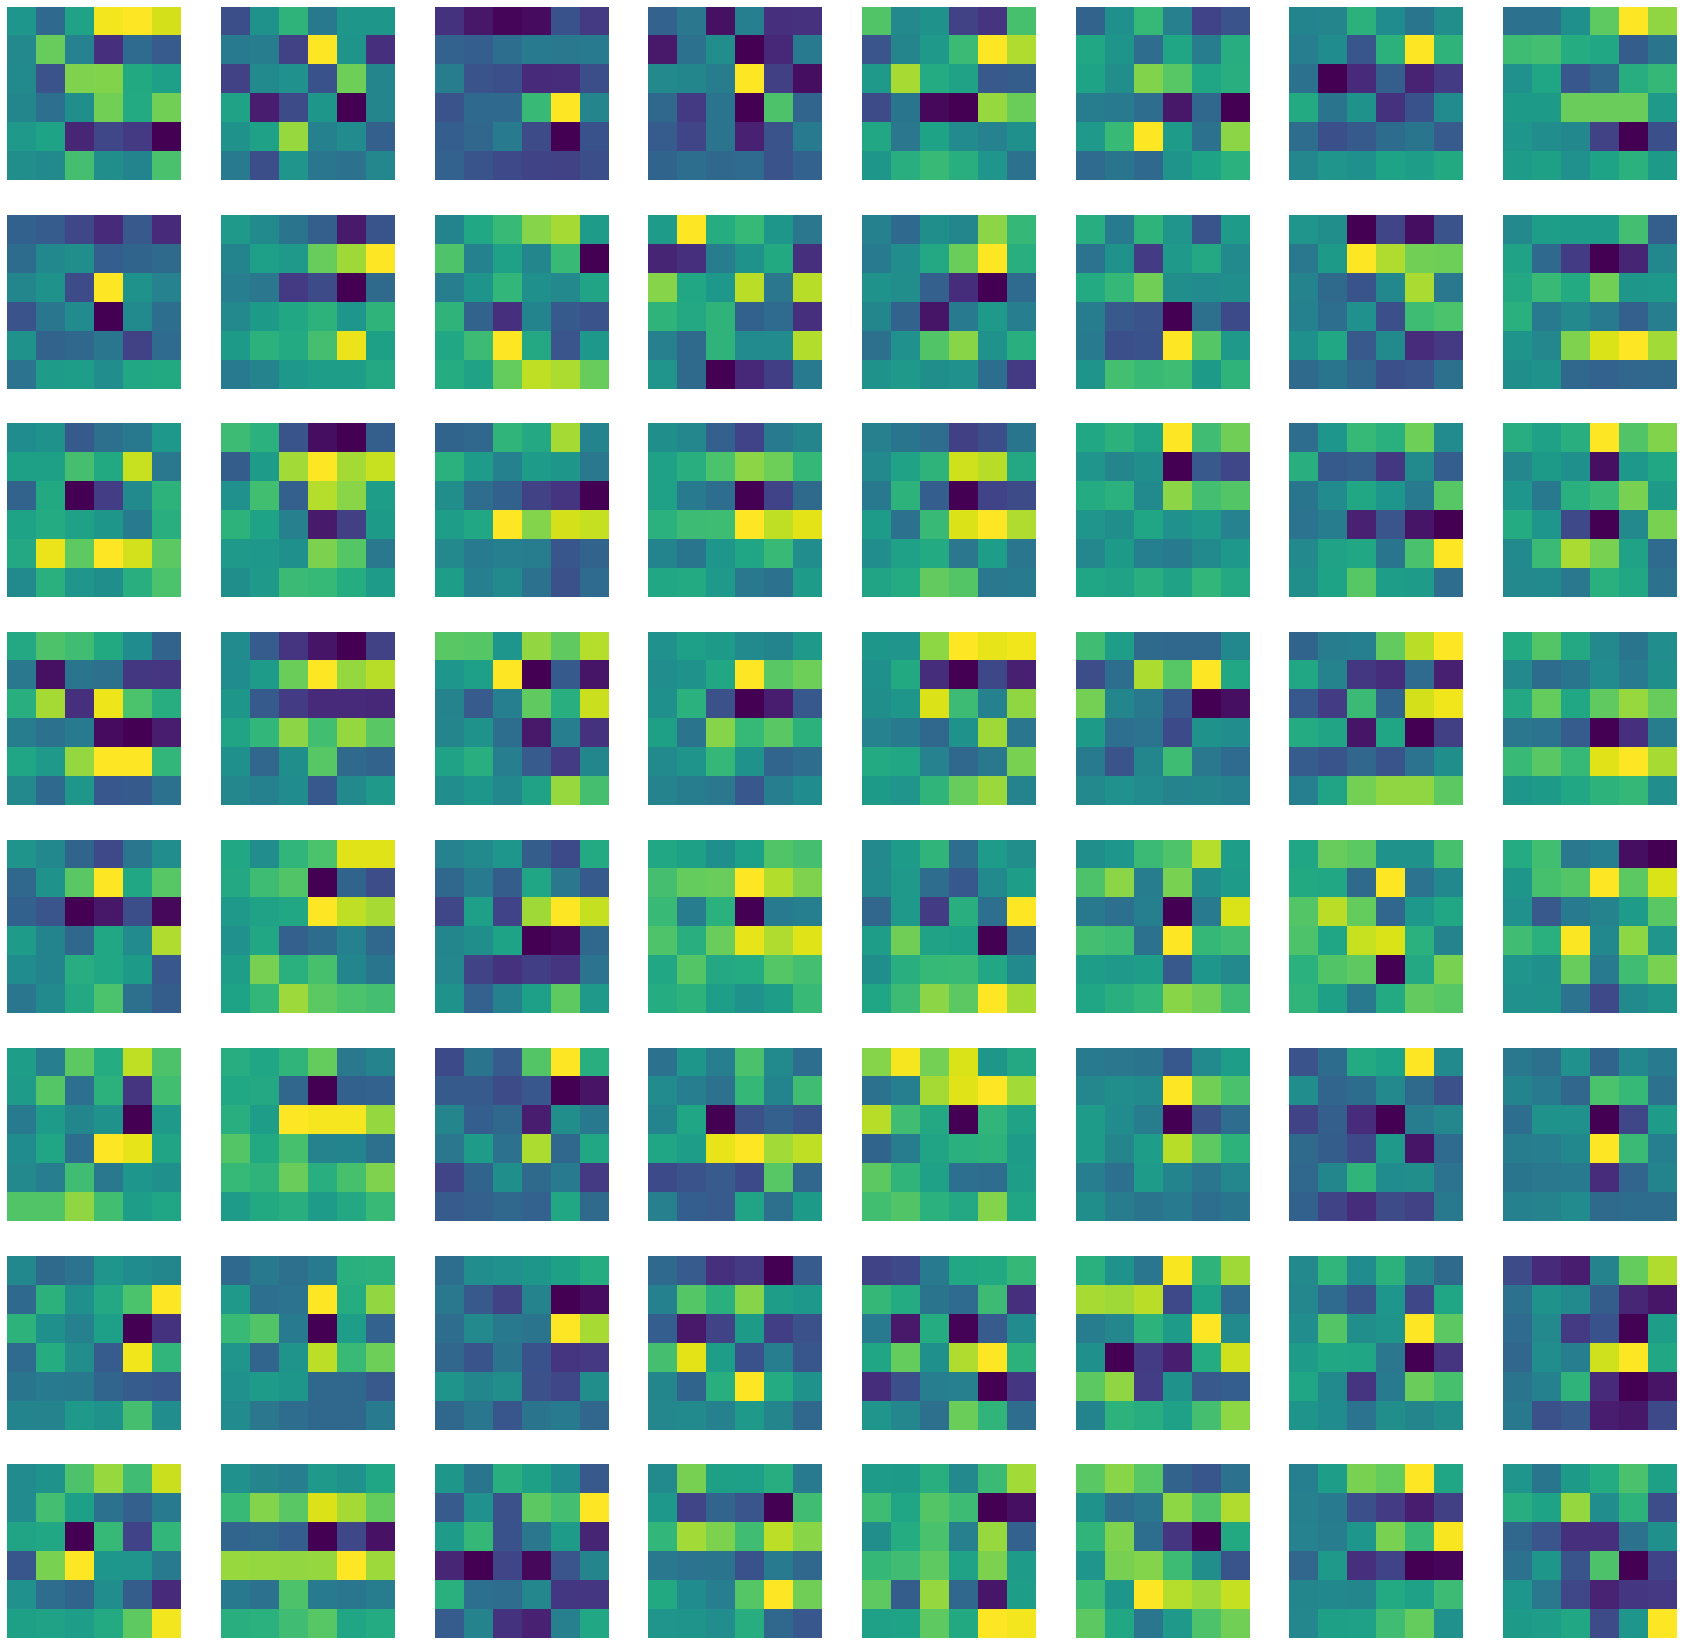

torch.Size([512, 6, 6])


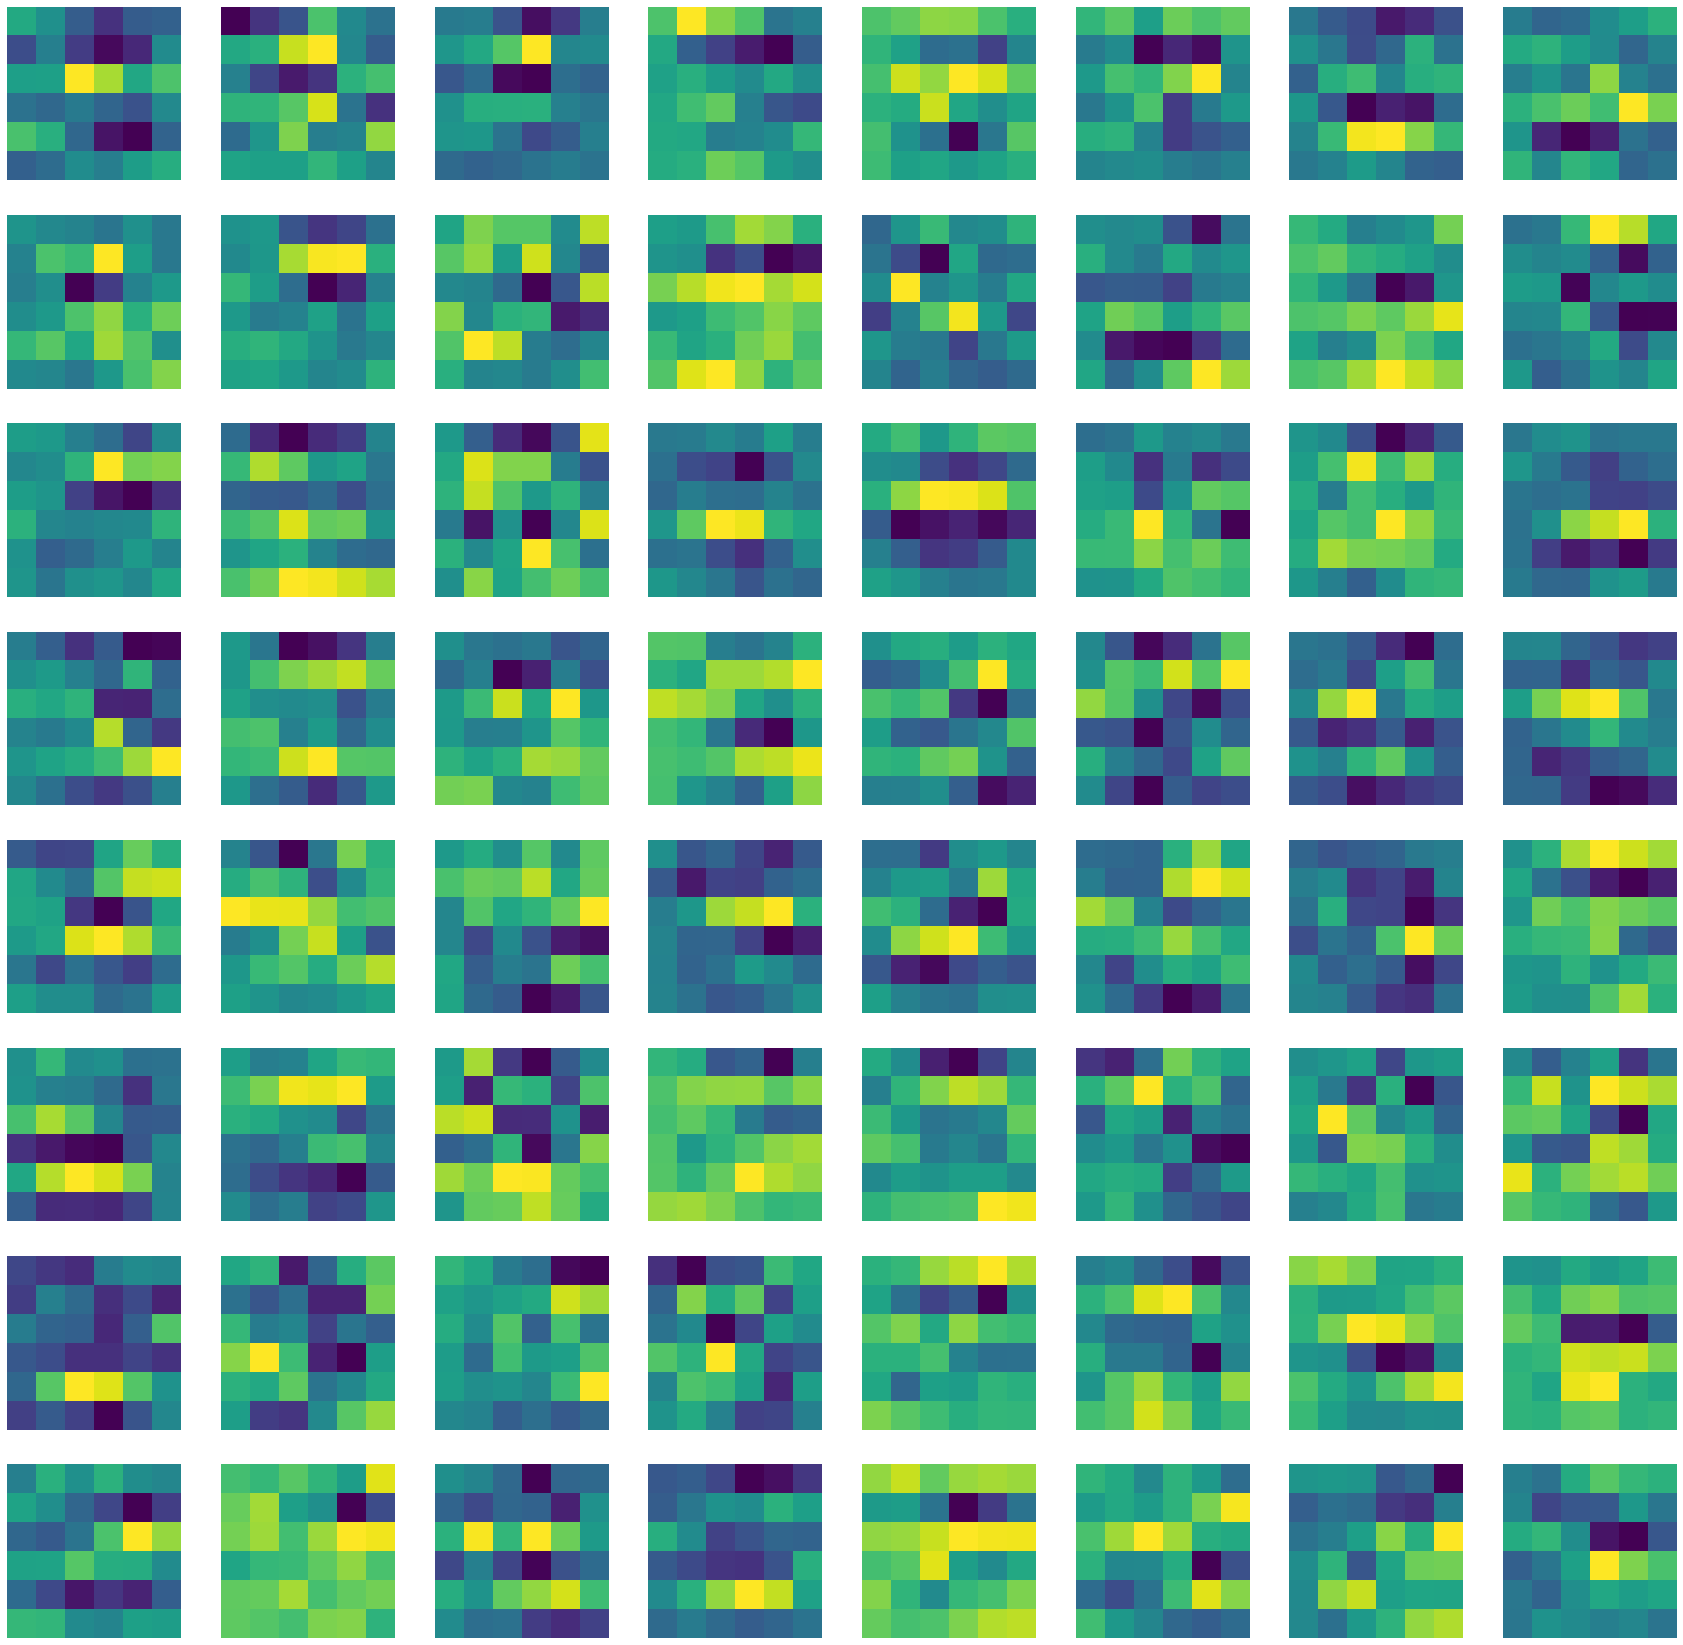

torch.Size([512, 6, 6])


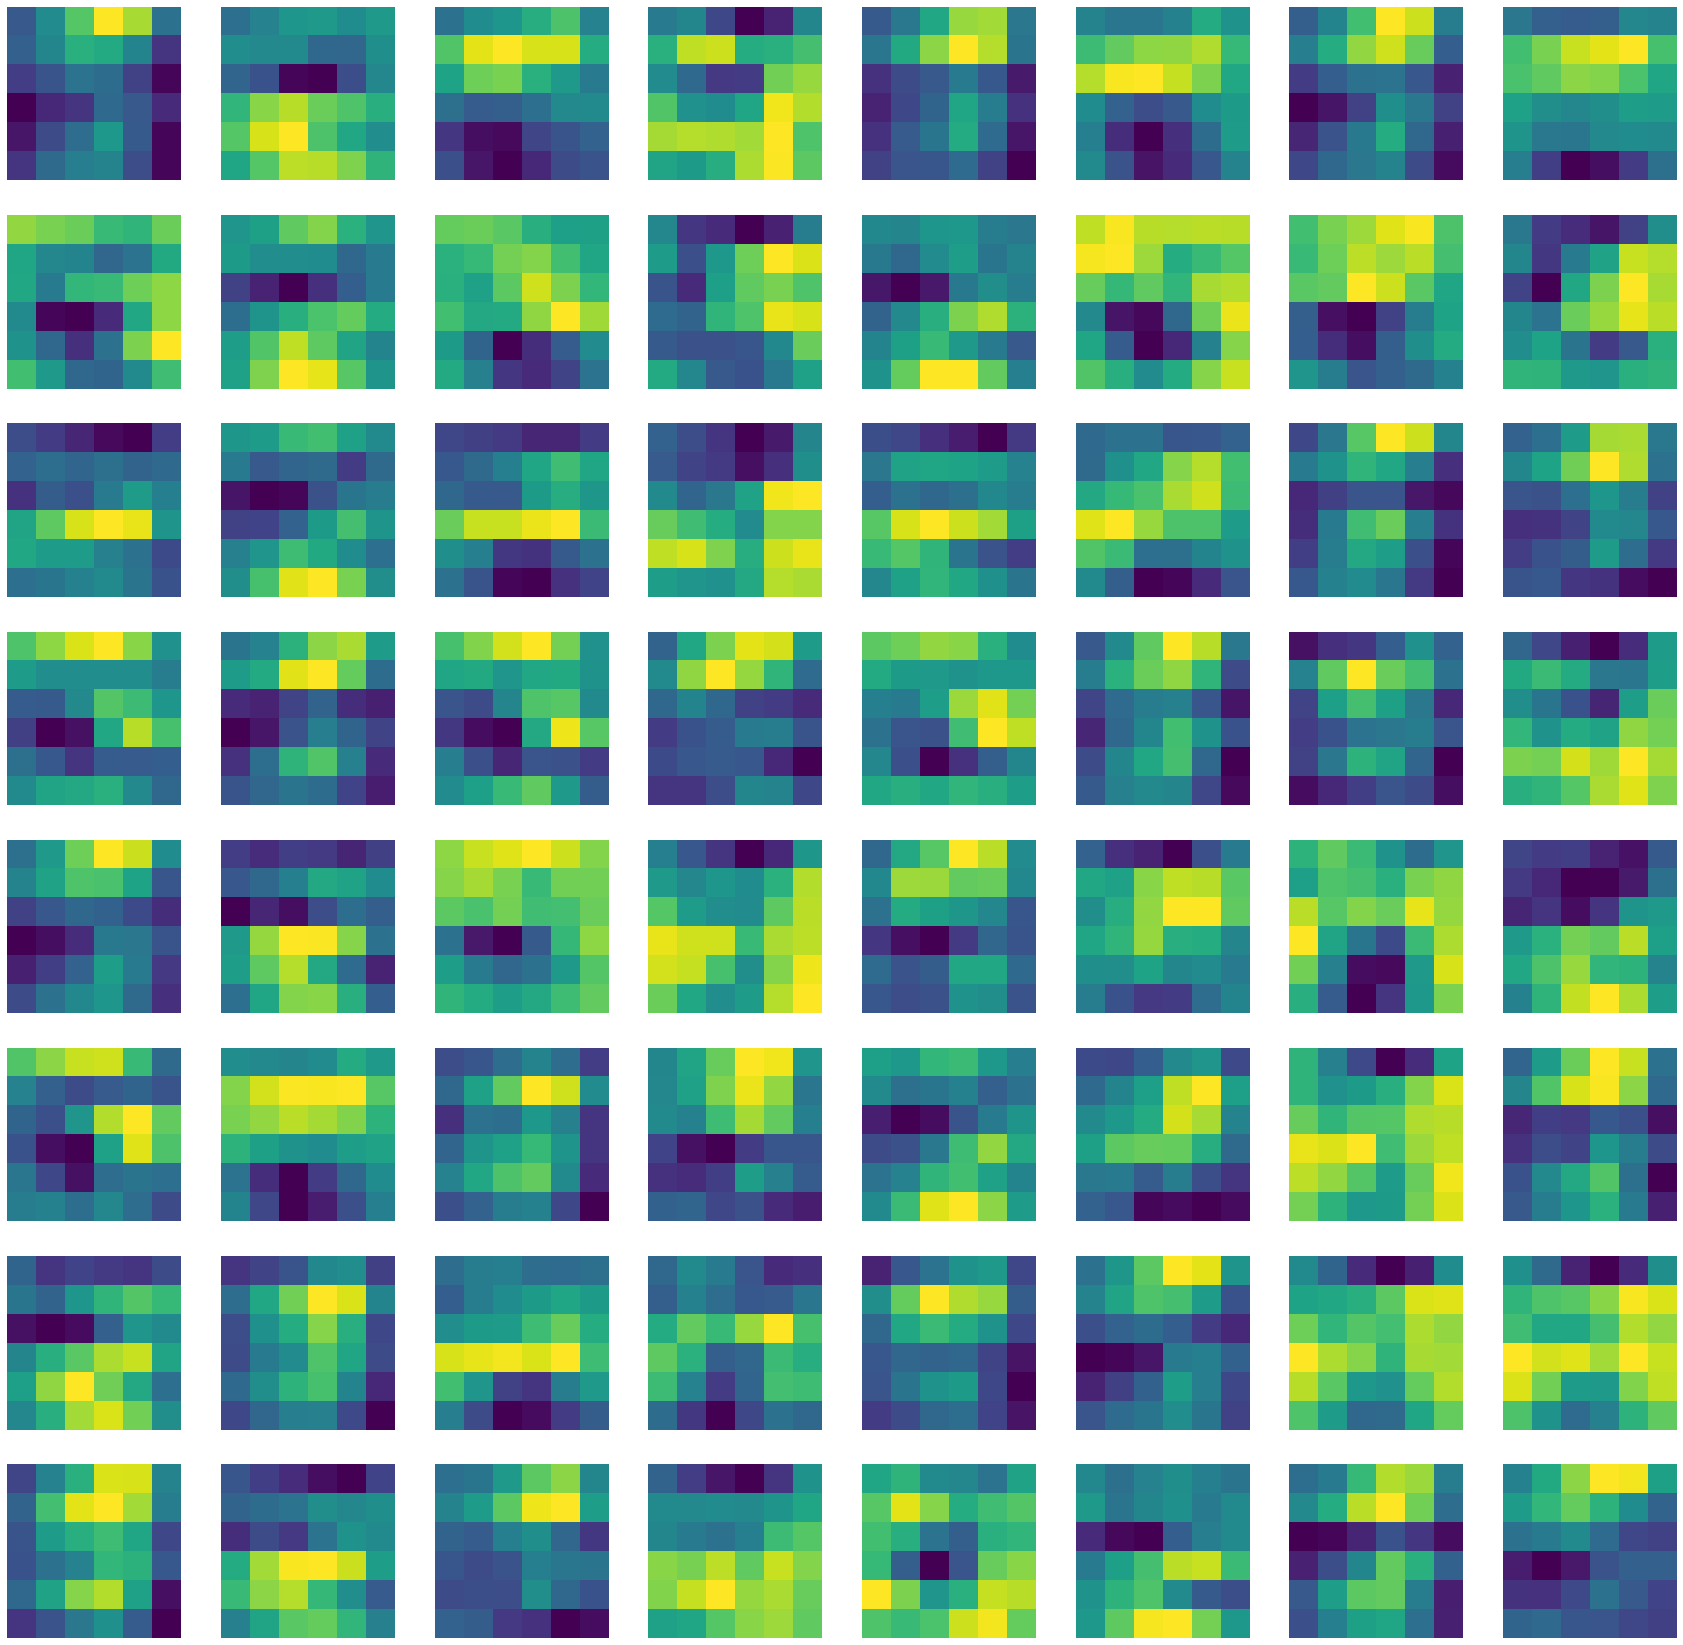

In [16]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 18 conv layers in this list

# counter to keep count of the conv layers
counter = 0 
model_children = list(saved_model.children())
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

# pass the image through all the layers
results = [conv_layers[0](Testloader.dataset[25][0].cuda())]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        filter = filter.cpu()
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter)
        plt.axis("off")
    # print(f"Saving layer {num_layer} feature maps...")
    # plt.savefig(f"../outputs/layer_{num_layer}.png")
    plt.show()
    plt.close()

In [ ]:
# #Visualize feature maps using hook
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

# saved_model.layer4.register_forward_hook(get_activation('layer4'))
# # data, _ = Testloader.dataset[25][0].cuda()
# # # data=data.to(device)
# # data.unsqueeze_(0)
# output = saved_model(Testloader.dataset[25][0].cuda())

# k=0
# act = activation['layer4'].squeeze()
# fig,ax = plt.subplots(2,2,figsize=(12, 15))

# print(activation['layer4'].shape)

# for i in range(act.size(0)//4):
#         for j in range(act.size(0)//4):
#            img=np.transpose(act[k].cpu(), (1, 2, 0))
#            ax[i,j].imshow(img.detach().numpy())
#            k+=1    
#           #  plt.savefig('fm1.png') 

In [113]:
saved_model

ResNet(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [137]:
list(saved_model.parameters())[-3]

saved_model.layer4[0].conv1.weight
# params = list(saved_model.parameters())
# weight = np.squeeze(params[-1].data.cpu().numpy())
print(conv_layers[-6])

print(saved_model.layer4[0].conv1.weight.shape)

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
torch.Size([512, 256, 3, 3])


In [ ]:
Testloader.dataset[25]

predicted:  Sad
id:  tensor(4, device='cuda:0')
weight_fc[class_idx]:  (512,)
feature_conv.reshape((nc, h*w)):  torch.Size([512, 36])
torch.Size([1, 48, 48])


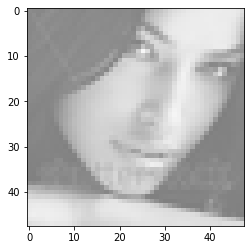

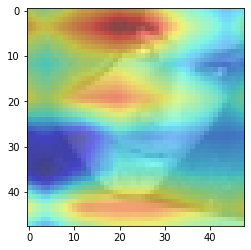

In [18]:
import skimage
from skimage.transform import resize

def getCAM(feature_conv, weight_fc, class_idx):
    nc, h, w = feature_conv.shape
    weight_fc = weight_fc.detach().numpy()
    print('weight_fc[class_idx]: ', weight_fc[class_idx].shape)
    print('feature_conv.reshape((nc, h*w)): ', feature_conv.reshape((nc, h*w)).shape)
    cam = np.matmul(weight_fc[class_idx], feature_conv.reshape((nc, h*w)).cpu().detach().numpy())
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    return [cam_img]



cut_size = 44
index=21

transform_test = transforms.Compose([
    transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])

Testset = dataset.FER2013(split = "Private_Test", transform=transform_test, csv_file=BASE_PATH + '/' + FER2013_PATH_FILE_NAME)
Testloader = torch.utils.data.DataLoader(Testset, batch_size=1, shuffle=False, num_workers=1)

transform_test1 = transforms.Compose([
    transforms.ToTensor()
])

Testset1 = dataset.FER2013(split = "Private_Test", transform=transform_test1, csv_file=BASE_PATH + '/' + FER2013_PATH_FILE_NAME)
Testloader1 = torch.utils.data.DataLoader(Testset1, batch_size=1, shuffle=False, num_workers=1)


    
# predicted_labels.append(idx[0])
# predicted =  train_loader.dataset.classes[idx[0]]
    
# print("Target: " + fname + " | Predicted: " +  predicted) 
 
# GET output of the last conv layer 
# pass the image through all the layers
results = [conv_layers[0](Testloader.dataset[index][0].cuda())]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))

# make a copy of the `results`
conv_outputs = results[-1]
# print('conv_outputs: ', conv_outputs.shape);
conv_outputs_avg = conv_outputs.mean(0)  # avg over crops
conv_outputs_avg.cpu().detach().numpy()


#Extract weight from trained model
# params = list(saved_model.parameters())
weight = saved_model.linear.weight
# weight = saved_model.layer4[0].conv1.weight

with torch.no_grad():
  outputs = saved_model(Testloader.dataset[index][0].cuda())
  # print('outputs: ', outputs)
  outputs_avg = outputs.view(ncrops, -1).mean(0)  # avg over crops
  # print('outputs_avg: ', outputs_avg)
  m = nn.Softmax(dim=-1)
  score = m(outputs_avg.data)
  # print('score : ', score)
  _, predicted = torch.max(outputs_avg.data, 0)
  print('predicted: ', emotion_labels[predicted.cpu().numpy()])
  print('id: ', predicted)

CAMs = getCAM(conv_outputs_avg, weight.cpu(), predicted)

# readImg = org_loc+fname+'.png'
# img = cv2.imread(readImg)
print(Testloader1.dataset[index][0].cuda().shape)
_,height, width = Testloader1.dataset[index][0].cuda().shape

img = Testloader1.dataset[index][0]
img=np.transpose(img, (1, 2, 0))
# print(img.shape)
img = img[:, :, 0]
img2 = np.zeros((48,48,3))
img2[:,:,0] = img
img2[:,:,1] = img
img2[:,:,2] = img

plt.imshow(img2, alpha=0.5, cmap='jet')
plt.show()
# plt.imshow(CAMs[0], alpha=0.5, cmap='jet')
# plt.show()
plt.imshow(img2, alpha=0.5, cmap='jet')
plt.imshow(skimage.transform.resize(CAMs[0], (width, height)), alpha=0.5, cmap='jet');
plt.show()
# heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
# result = heatmap * 0.5 + img * 0.5
  
# cv2.imwrite("image_1", result)